## This notebook will help you train a raw Point-Cloud GAN.

(Assumes latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import point_cloud_generator,\
mlp_discriminator, leaky_relu

/home/dmri/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Use to save Neural-Net check-points etc.
top_out_dir = '../data/'          

# Top-dir of where point-clouds are stored.
top_in_dir = '../data/ear_data/'

experiment_name = 'raw_ear_gan_with_w_gan_loss'

n_pc_points = 2048                # Number of points per model.
#class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
#class_name = "chair"

In [4]:
# Load point-clouds.
#syn_id = snc_category_to_synth_id()[class_name]
#class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(top_in_dir, n_threads=8, file_ending='.ply', verbose=True)
print('Shape of DATA =', all_pc_data.point_clouds.shape)

297 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (297, 2048, 3)


/home/dmri/github/latent_3d_points/src/in_out.py:133: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


Set GAN parameters.

In [5]:
use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 5000       # Epochs to train.

plot_train_curve = True
save_gan_model = True
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = all_pc_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
beta = 0.5 # ADAM's momentum.

n_out = [n_pc_points, 3] # Dimensionality of generated samples.


discriminator = mlp_discriminator
generator = point_cloud_generator

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/raw_gan', experiment_name)
    create_dir(train_dir)

In [7]:
reset_tf_graph()

if use_wgan:
    lam = 10
    disc_kwargs = {'b_norm': False}
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,
                    discriminator, generator,
                    disc_kwargs=disc_kwargs, beta=beta)
    
else:    
    leak = 0.2
    disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                      discriminator, generator, beta=beta, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (7.323589134216308, 0.04556366428732872)
INFO:tensorflow:../data/OUT/raw_gan/raw_ear_gan_with_w_gan_loss/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


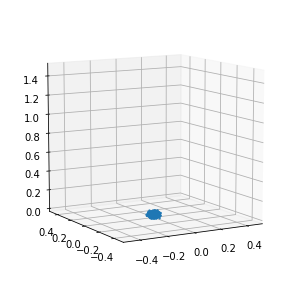

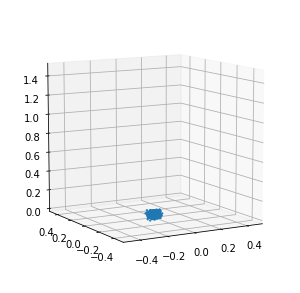

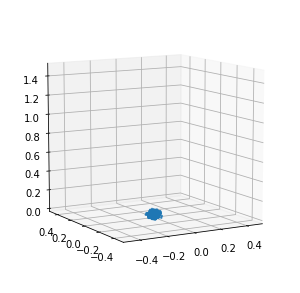

2 (5.273339939117432, 0.07297346740961075)
3 (3.323500394821167, 0.09532076120376587)
4 (1.841528844833374, 0.10515061020851135)
5 (1.2898640394210816, 0.12321315705776215)
INFO:tensorflow:../data/OUT/raw_gan/raw_ear_gan_with_w_gan_loss/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


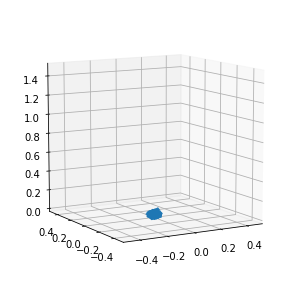

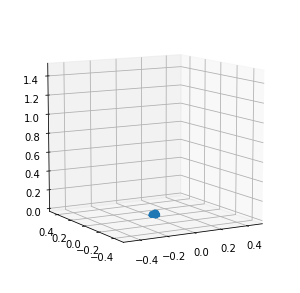

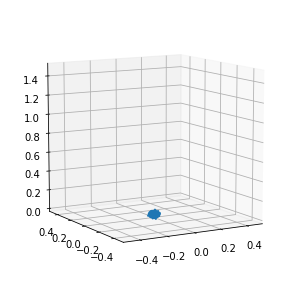

6 (1.1907652139663696, 0.14575442671775818)
7 (0.8833457231521606, 0.16512702405452728)
8 (0.7924919486045837, 0.18994106352329254)
9 (0.40627204179763793, 0.2085997760295868)
10 (0.44627108573913576, 0.25075623393058777)
INFO:tensorflow:../data/OUT/raw_gan/raw_ear_gan_with_w_gan_loss/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


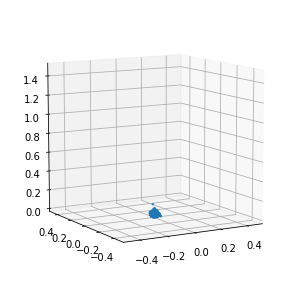

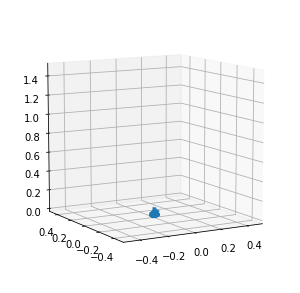

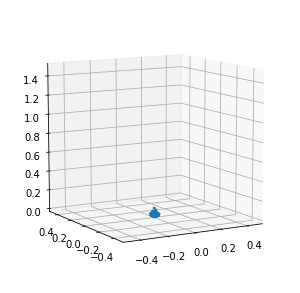

11 (-0.12888143062591553, 0.2847384512424469)
12 (-0.3581185579299927, 0.31618064641952515)
13 (-0.5610618591308594, 0.33603110909461975)
14 (-0.7414238095283509, 0.3424641489982605)
15 (-0.9520214080810547, 0.35429298877716064)
16 (-1.0847484588623046, 0.3629862666130066)
17 (-1.2007837772369385, 0.3997463285923004)
18 (-1.3655063390731812, 0.4021276831626892)
19 (-1.3991127490997315, 0.4019429087638855)
20 (-1.5114114046096803, 0.4641224145889282)
21 (-1.68728666305542, 0.4587950110435486)
22 (-1.6982096433639526, 0.48998382687568665)
23 (-1.804505181312561, 0.5753380060195923)
24 (-1.8570621490478516, 0.6406477093696594)
25 (-1.8538615226745605, 0.7567341327667236)
26 (-1.996061372756958, 0.8917762637138367)
27 (-1.958833885192871, 0.9991183280944824)
28 (-2.0241796731948853, 1.118991732597351)
29 (-2.090717625617981, 1.198909878730774)
30 (-2.178797721862793, 1.4008984565734863)
31 (-2.1849708795547484, 1.4091856479644775)
32 (-2.2747105598449706, 1.6018433570861816)
33 (-2.2429919

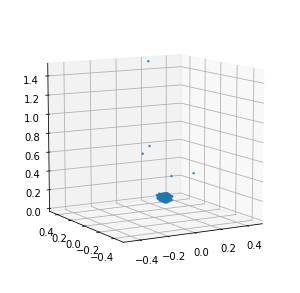

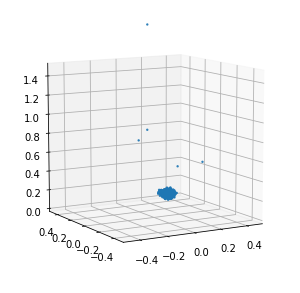

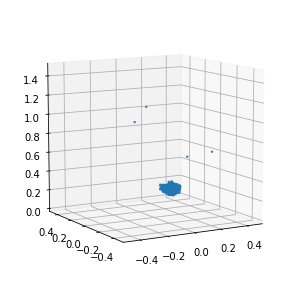

51 (-2.1241516351699827, 2.643524408340454)
52 (-2.0624712467193604, 2.6391208171844482)
53 (-1.8975543975830078, 2.7800710201263428)
54 (-2.0078394412994385, 2.884211540222168)
55 (-1.8603853225708007, 3.163581609725952)
56 (-1.948755955696106, 3.193155527114868)
57 (-2.001688599586487, 3.18837308883667)
58 (-1.7806993007659913, 3.3802390098571777)
59 (-1.8431924343109132, 3.2536051273345947)
60 (-1.8613072872161864, 3.1425087451934814)
61 (-1.6847378253936767, 3.1297945976257324)
62 (-1.6942096948623657, 3.0745718479156494)
63 (-1.5696043014526366, 3.0815186500549316)
64 (-1.546421504020691, 3.1446621417999268)
65 (-1.5611383438110351, 3.168861150741577)
66 (-1.3644500494003295, 3.3897593021392822)
67 (-1.503217911720276, 3.3448233604431152)
68 (-1.6695185661315919, 3.217400550842285)
69 (-1.5772882461547852, 3.1733336448669434)
70 (-1.3343487501144409, 3.2952404022216797)
71 (-1.174348521232605, 3.528395652770996)
72 (-1.31993066072464, 3.3235883712768555)
73 (-1.2450502634048461, 3

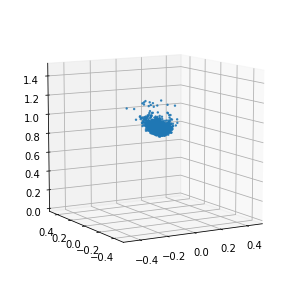

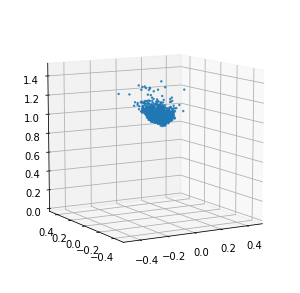

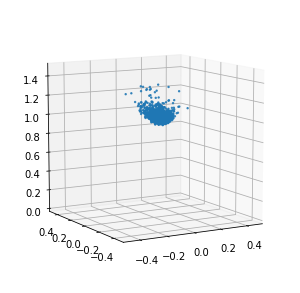

101 (-0.011084613204002381, 2.9554367065429688)
102 (-0.046203887462615965, 3.0976531505584717)
103 (-0.04162413775920868, 3.227785110473633)
104 (-0.06050835251808166, 3.079740285873413)
105 (0.06266001760959625, 3.078660488128662)
106 (0.0620363712310791, 3.0507445335388184)
107 (0.08930560946464539, 3.287104845046997)
108 (0.18490258753299713, 3.3270349502563477)
109 (0.15960294008255005, 3.329322099685669)
110 (0.1504212200641632, 3.0332019329071045)
111 (0.16253650486469268, 2.939737558364868)
112 (0.1372374713420868, 2.8680968284606934)
113 (0.028938069939613342, 2.9342992305755615)
114 (0.07567359507083893, 2.605668544769287)
115 (0.0965411752462387, 2.942439556121826)
116 (0.019954419136047362, 2.584120750427246)
117 (0.04557331204414368, 2.8313028812408447)
118 (0.020422670245170593, 2.665030002593994)
119 (0.08739503026008606, 3.229839563369751)
120 (0.05189346969127655, 3.3234777450561523)
121 (0.06700152754783631, 3.203270673751831)
122 (0.05815331041812897, 2.7600438594818

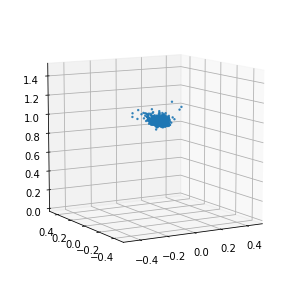

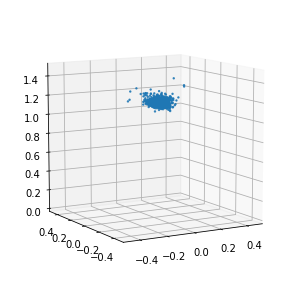

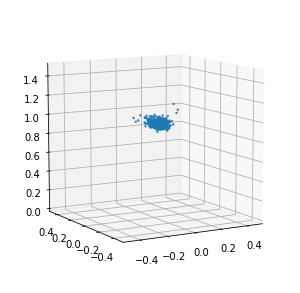

151 (-0.1444445312023163, 2.319862127304077)
152 (-0.04005581736564636, 1.7363587617874146)
153 (-0.15173177123069764, 1.871883511543274)
154 (-0.13448971807956694, 2.0312163829803467)
155 (-0.15181505382061006, 2.208707332611084)
156 (-0.09123755395412445, 2.327023506164551)
157 (-0.1635388344526291, 2.3693456649780273)
158 (-0.05002966523170471, 2.4712724685668945)
159 (-0.09450527429580688, 2.262737512588501)
160 (-0.14686326831579208, 2.041325092315674)
161 (-0.155496221780777, 2.0991272926330566)
162 (-0.22151883840560913, 2.415335178375244)
163 (-0.27176414132118226, 2.3337786197662354)
164 (-0.11935333609580993, 1.8392739295959473)
165 (-0.12931459844112397, 2.2837517261505127)
166 (-0.14010393619537354, 2.1557302474975586)
167 (-0.07510958313941955, 1.8836243152618408)
168 (-0.08722933232784272, 1.8345016241073608)
169 (-0.19045604765415192, 2.334744691848755)
170 (-0.12611594498157502, 2.1073455810546875)
171 (-0.0866248220205307, 1.9843034744262695)
172 (-0.19054073393344878,

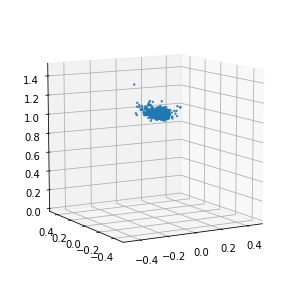

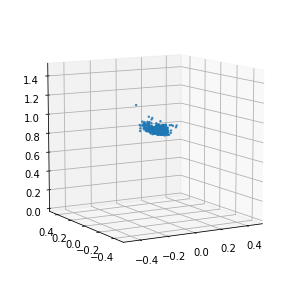

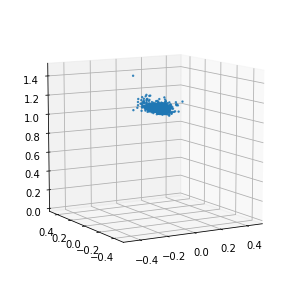

201 (-0.10795777440071105, 1.9359939098358154)
202 (-0.2101951539516449, 2.0413265228271484)
203 (-0.20175439715385438, 2.000429391860962)
204 (-0.16214712858200073, 1.864870309829712)
205 (-0.12324690371751786, 1.8529839515686035)
206 (-0.1403185546398163, 1.8913334608078003)
207 (-0.18604307770729064, 1.7462538480758667)
208 (-0.13972118198871614, 1.8679279088974)
209 (-0.22025085389614105, 2.0718448162078857)
210 (-0.20270437896251678, 1.9810421466827393)
211 (-0.15470655858516694, 1.7661703824996948)
212 (-0.14485620260238646, 2.0930943489074707)
213 (-0.17698967456817627, 1.7938804626464844)
214 (-0.20826013684272765, 1.9044338464736938)
215 (-0.23530831038951874, 1.8629062175750732)
216 (-0.1763617843389511, 1.87394380569458)
217 (-0.21634312868118286, 2.1939780712127686)
218 (-0.22844735980033876, 1.9943220615386963)
219 (-0.2389782637357712, 1.9705514907836914)
220 (-0.25219239890575407, 2.017331600189209)
221 (-0.19300312101840972, 1.7513941526412964)
222 (-0.21057043075561524

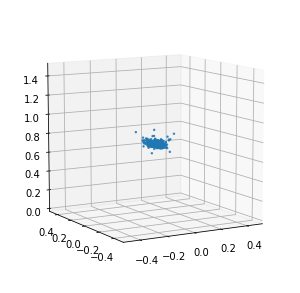

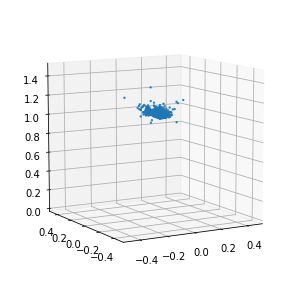

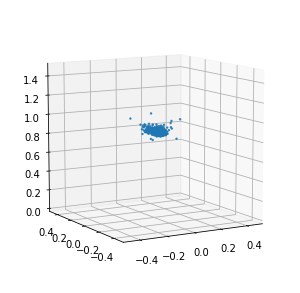

251 (-0.16716140508651733, 1.9318698644638062)
252 (-0.18222854137420655, 1.8777368068695068)
253 (-0.15175395607948303, 1.7726147174835205)
254 (-0.2331518769264221, 1.917423963546753)
255 (-0.23597384691238404, 1.7845580577850342)
256 (-0.27006527185440066, 1.6807796955108643)
257 (-0.20243074297904967, 1.6803975105285645)
258 (-0.329843270778656, 1.7852383852005005)
259 (-0.2612243205308914, 2.0001773834228516)
260 (-0.17815358936786652, 1.8234912157058716)
261 (-0.23397498726844787, 1.8581334352493286)
262 (-0.26044431924819944, 1.7854430675506592)
263 (-0.30176842212677, 1.660539150238037)
264 (-0.31744282245635985, 1.634061336517334)
265 (-0.25438264608383176, 1.9477826356887817)
266 (-0.30728834569454194, 1.9209344387054443)
267 (-0.29960536360740664, 1.6925148963928223)
268 (-0.26462452709674833, 1.8184760808944702)
269 (-0.2890329480171204, 1.8606780767440796)
270 (-0.293392950296402, 1.8911786079406738)
271 (-0.204768568277359, 1.8989866971969604)
272 (-0.18272658288478852, 1

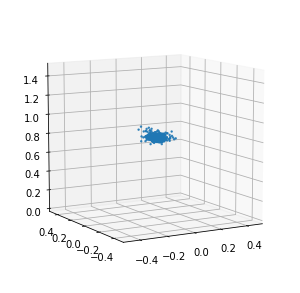

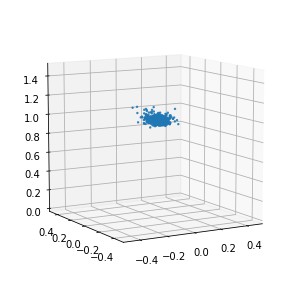

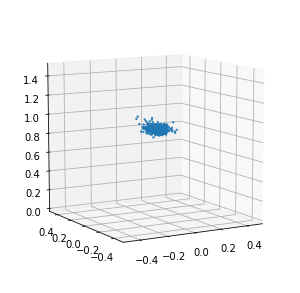

301 (-0.2542481690645218, 1.5786746740341187)
302 (-0.2982783496379852, 1.7397652864456177)
303 (-0.2961098521947861, 1.9417544603347778)
304 (-0.3339467287063599, 1.8718987703323364)
305 (-0.2232319563627243, 1.7031207084655762)
306 (-0.289900130033493, 1.7087233066558838)
307 (-0.2948376268148422, 1.706166386604309)
308 (-0.32595382928848265, 1.7819381952285767)
309 (-0.2775989562273026, 1.8134595155715942)
310 (-0.2898130178451538, 1.9222991466522217)
311 (-0.311559921503067, 1.8985601663589478)
312 (-0.359501314163208, 1.785852313041687)
313 (-0.2914437294006348, 1.8352770805358887)
314 (-0.22746556401252746, 1.728582739830017)
315 (-0.2268034726381302, 1.8443413972854614)
316 (-0.23216496407985687, 1.8264857530593872)
317 (-0.25457329154014585, 1.8130621910095215)
318 (-0.30895302891731263, 1.6562788486480713)
319 (-0.27926182746887207, 1.6749159097671509)
320 (-0.25213088393211364, 1.648787498474121)
321 (-0.3131749451160431, 1.8820393085479736)
322 (-0.3225809633731842, 1.951809

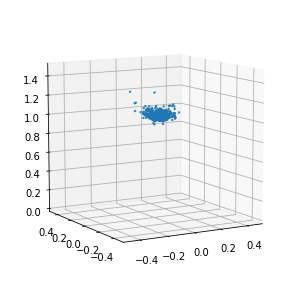

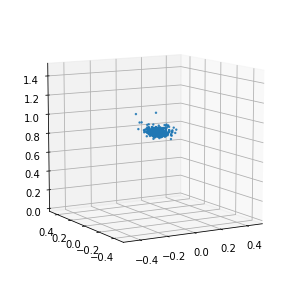

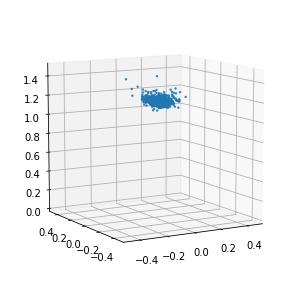

351 (-0.33460748195648193, 1.7171026468276978)
352 (-0.27676927447319033, 1.5712109804153442)
353 (-0.33585814833641053, 1.453619122505188)
354 (-0.2872278571128845, 1.382755994796753)
355 (-0.37759984135627744, 1.5448431968688965)
356 (-0.30790364146232607, 1.7899534702301025)
357 (-0.3198320597410202, 1.6633944511413574)
358 (-0.345648980140686, 1.6622881889343262)
359 (-0.3621963977813721, 1.563629150390625)
360 (-0.3273048520088196, 1.635198712348938)
361 (-0.30556233525276183, 1.741980791091919)
362 (-0.24259105920791627, 1.6913899183273315)
363 (-0.2020323246717453, 1.619535207748413)
364 (-0.20663748383522035, 1.5284188985824585)
365 (-0.2554152637720108, 1.3679213523864746)
366 (-0.271579909324646, 1.2946697473526)
367 (-0.3387706816196442, 1.6156567335128784)
368 (-0.23398274183273315, 1.5426214933395386)
369 (-0.27165726721286776, 1.2373051643371582)
370 (-0.18409839570522307, 1.3017785549163818)
371 (-0.21861013472080232, 1.4578068256378174)
372 (-0.26071256697177886, 1.1822

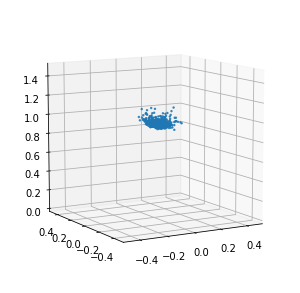

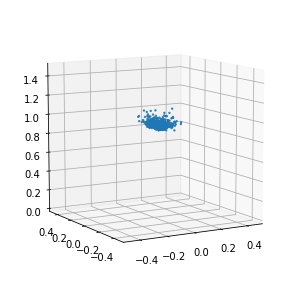

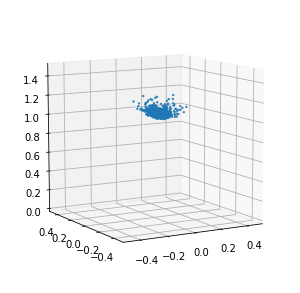

401 (-0.2856151819229126, 1.4149340391159058)
402 (-0.3439470291137695, 1.4142663478851318)
403 (-0.2936358392238617, 1.3283522129058838)
404 (-0.28902165293693544, 1.524239182472229)
405 (-0.36217573285102844, 1.7441742420196533)
406 (-0.35229410529136657, 1.4447135925292969)
407 (-0.37721710205078124, 1.501633644104004)
408 (-0.36552309393882754, 1.2994991540908813)
409 (-0.3071847796440125, 1.3852341175079346)
410 (-0.30491977334022524, 1.2951993942260742)
411 (-0.3798569142818451, 1.475313663482666)
412 (-0.33985260128974915, 1.4781886339187622)
413 (-0.27248992025852203, 1.4957842826843262)
414 (-0.24240959584712982, 1.5097229480743408)
415 (-0.2881937801837921, 1.4077426195144653)
416 (-0.21645726263523102, 1.645025372505188)
417 (-0.3276287794113159, 1.536482810974121)
418 (-0.30236163139343264, 1.4033981561660767)
419 (-0.35188435316085814, 1.4431060552597046)
420 (-0.3097059726715088, 1.4257718324661255)
421 (-0.3112497001886368, 1.31980562210083)
422 (-0.2911748498678207, 1.4

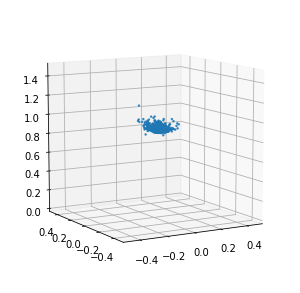

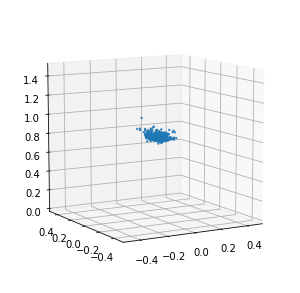

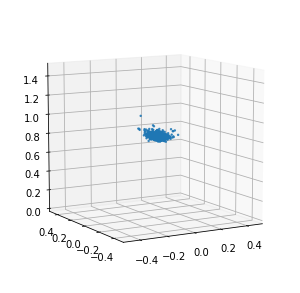

451 (-0.3194661796092987, 1.0843174457550049)
452 (-0.2928599685430527, 1.3358880281448364)
453 (-0.3118652880191803, 1.3487880229949951)
454 (-0.291585373878479, 1.3953953981399536)
455 (-0.30120788514614105, 1.4732856750488281)
456 (-0.3438667893409729, 1.4183000326156616)
457 (-0.2865441024303436, 1.3456337451934814)
458 (-0.23456996083259582, 1.264957308769226)
459 (-0.22872060537338257, 1.25502347946167)
460 (-0.21870071291923524, 1.494330883026123)
461 (-0.31576781868934634, 1.2774845361709595)
462 (-0.22980207204818726, 1.0648109912872314)
463 (-0.22946012914180755, 1.1748285293579102)
464 (-0.22541301250457763, 1.185314655303955)
465 (-0.2088256895542145, 1.3603259325027466)
466 (-0.3411759674549103, 1.2336394786834717)
467 (-0.27423152327537537, 1.1517280340194702)
468 (-0.3072208344936371, 1.1631402969360352)
469 (-0.24351786673069, 1.0205903053283691)
470 (-0.28039300739765166, 1.141215443611145)
471 (-0.27835284173488617, 1.0085088014602661)
472 (-0.2148597478866577, 1.1278

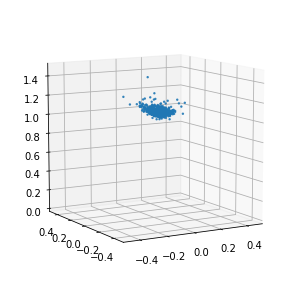

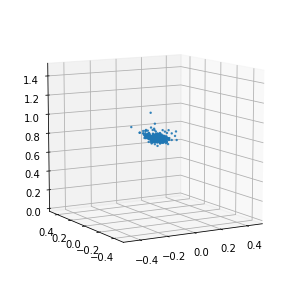

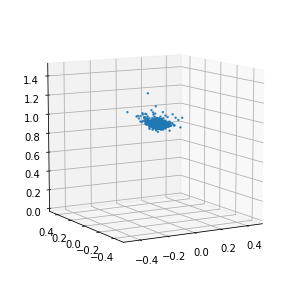

501 (-0.3208556056022644, 1.266899585723877)
502 (-0.3161658555269241, 1.229640007019043)
503 (-0.3057603657245636, 1.4506924152374268)
504 (-0.3366434156894684, 1.5676897764205933)
505 (-0.2918019413948059, 1.4727550745010376)
506 (-0.2504820883274078, 1.3421735763549805)
507 (-0.2911569058895111, 1.2782258987426758)
508 (-0.2678031623363495, 1.2518181800842285)
509 (-0.2149142563343048, 1.0304354429244995)
510 (-0.23246791064739228, 1.2559962272644043)
511 (-0.27707032561302186, 1.1781888008117676)
512 (-0.24721519649028778, 1.0484243631362915)
513 (-0.30318673253059386, 1.0963711738586426)
514 (-0.2810157239437103, 1.0616545677185059)
515 (-0.20230752527713775, 1.1439945697784424)
516 (-0.25950894355773924, 1.1064033508300781)
517 (-0.2121421903371811, 0.8847688436508179)
518 (-0.27445698380470274, 1.0224170684814453)
519 (-0.2100067228078842, 0.9868736267089844)
520 (-0.3161801755428314, 1.0955514907836914)
521 (-0.37026287317276, 1.0125104188919067)
522 (-0.3658020496368408, 1.079

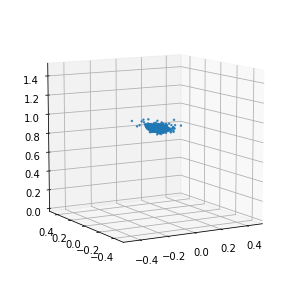

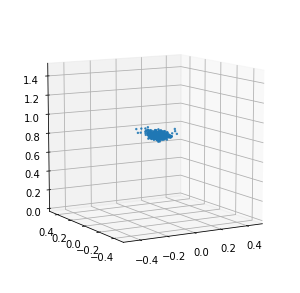

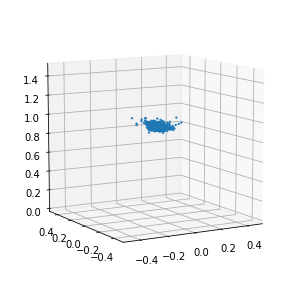

551 (-0.30205942392349244, 1.0561941862106323)
552 (-0.19930680990219116, 0.9569486379623413)
553 (-0.29844951033592226, 1.1101579666137695)
554 (-0.22557927668094635, 1.0826280117034912)
555 (-0.2598542094230652, 1.0939737558364868)
556 (-0.24603679776191711, 1.060484766960144)
557 (-0.2464908629655838, 0.9492077827453613)
558 (-0.30122936964035035, 1.0435523986816406)
559 (-0.3194155514240265, 1.1372467279434204)
560 (-0.3391407310962677, 1.1534837484359741)
561 (-0.3043093144893646, 1.0279242992401123)
562 (-0.2762295097112656, 1.2325053215026855)
563 (-0.28590443134307864, 1.2071361541748047)
564 (-0.2937121629714966, 1.194825291633606)
565 (-0.34224212169647217, 1.203212857246399)
566 (-0.253389498591423, 1.2139829397201538)
567 (-0.2784491956233978, 1.0396816730499268)
568 (-0.26450193524360655, 0.9448501467704773)
569 (-0.21789602637290956, 1.011224627494812)
570 (-0.2333125501871109, 1.1170233488082886)
571 (-0.2456245630979538, 1.0883166790008545)
572 (-0.2094864010810852, 0.9

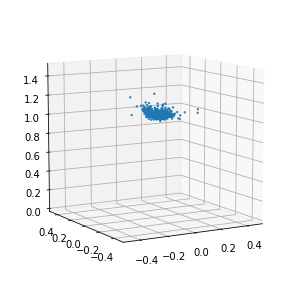

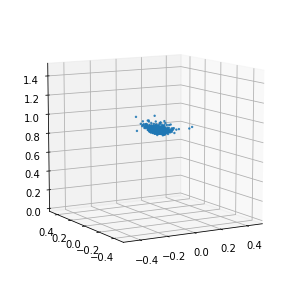

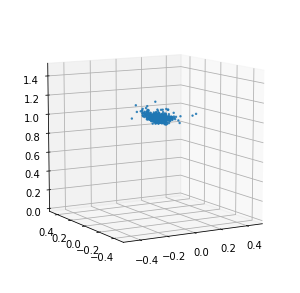

601 (-0.3451253592967987, 1.1204510927200317)
602 (-0.2814061135053635, 1.0602874755859375)
603 (-0.26253487169742584, 0.9850300550460815)
604 (-0.2934179544448853, 1.005030870437622)
605 (-0.25491513013839723, 0.8906342387199402)
606 (-0.2879355728626251, 0.9788061380386353)
607 (-0.22585005462169647, 0.8968279957771301)
608 (-0.1991271823644638, 0.8102067708969116)
609 (-0.26805697083473207, 0.9339954853057861)
610 (-0.3060140311717987, 1.1102551221847534)
611 (-0.2379041999578476, 0.8958485126495361)
612 (-0.33200864791870116, 1.0131696462631226)
613 (-0.17511030435562133, 0.9764679074287415)
614 (-0.1895776778459549, 0.6674067974090576)
615 (-0.15499813258647918, 0.6786491870880127)
616 (-0.20257363915443422, 0.6606332659721375)
617 (-0.29075766205787656, 0.7483906745910645)
618 (-0.2583364903926849, 0.9417315125465393)
619 (-0.23988081514835358, 1.0314266681671143)
620 (-0.2863068014383316, 0.8933740258216858)
621 (-0.30995193123817444, 0.9725439548492432)
622 (-0.362065726518631,

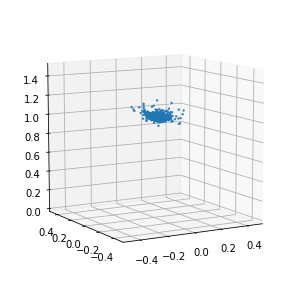

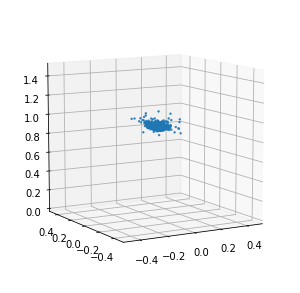

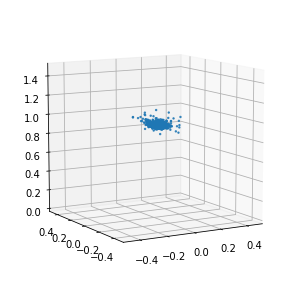

651 (-0.28458558917045595, 0.9345613121986389)
652 (-0.2378992885351181, 0.8939712643623352)
653 (-0.22863243520259857, 0.8727867007255554)
654 (-0.2790115028619766, 0.8957149982452393)
655 (-0.2359438419342041, 0.8647517561912537)
656 (-0.2691081017255783, 0.8991578817367554)
657 (-0.1765473961830139, 1.2308682203292847)
658 (-0.26412499845027926, 1.0640836954116821)
659 (-0.23614947497844696, 0.8523602485656738)
660 (-0.25154933929443357, 0.8000134229660034)
661 (-0.24874098896980285, 0.8758422136306763)
662 (-0.2541411191225052, 0.7929813861846924)
663 (-0.30742932558059693, 0.9484606981277466)
664 (-0.2802675783634186, 0.7819624543190002)
665 (-0.33003312945365904, 0.8459331393241882)
666 (-0.34141902923583983, 0.8755560517311096)
667 (-0.284064507484436, 0.9495968818664551)
668 (-0.25013343393802645, 0.8584741353988647)
669 (-0.34085997343063357, 0.9929924011230469)
670 (-0.2756562829017639, 0.8772978782653809)
671 (-0.1888204276561737, 0.8360077142715454)
672 (-0.2709732562303543

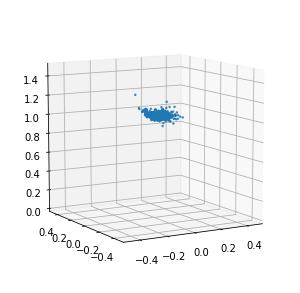

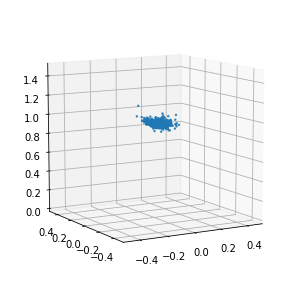

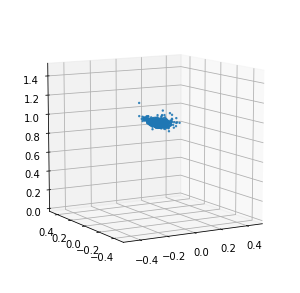

701 (-0.20499195754528046, 0.4682377576828003)
702 (-0.27610103487968446, 0.65088951587677)
703 (-0.3527301251888275, 0.8161200881004333)
704 (-0.333538693189621, 0.9535617232322693)
705 (-0.3192798852920532, 0.7184478640556335)
706 (-0.2872913837432861, 0.7689456343650818)
707 (-0.29685171246528624, 0.7421202659606934)
708 (-0.27198635041713715, 0.7509774565696716)
709 (-0.2910331428050995, 0.755622386932373)
710 (-0.23771060407161712, 0.5888341665267944)
711 (-0.23136218190193175, 0.6727824211120605)
712 (-0.2195274204015732, 0.7041964530944824)
713 (-0.2244667425751686, 0.6244766712188721)
714 (-0.32703625559806826, 0.7174050807952881)
715 (-0.30294483006000517, 0.700340211391449)
716 (-0.4132314145565033, 0.6026732921600342)
717 (-0.3317819356918335, 0.5183062553405762)
718 (-0.36188845038414, 0.8269326090812683)
719 (-0.24851391315460206, 0.8399516344070435)
720 (-0.2747471213340759, 0.7378333210945129)
721 (-0.252575558423996, 0.5629062056541443)
722 (-0.2564549595117569, 0.53959

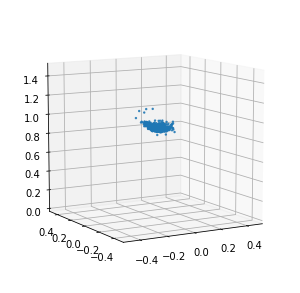

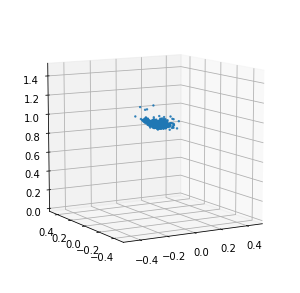

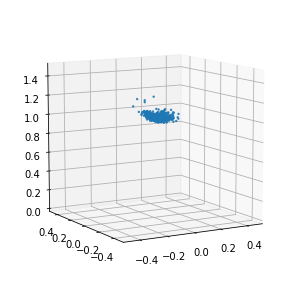

751 (-0.3955104470252991, 0.8100464344024658)
752 (-0.22247104048728944, 0.6018517017364502)
753 (-0.2201706200838089, 0.5362287759780884)
754 (-0.2763335645198822, 0.6572007536888123)
755 (-0.32456094622612, 0.6218502521514893)
756 (-0.34566739201545715, 0.4858725070953369)
757 (-0.26272197663784025, 0.31752675771713257)
758 (-0.27045519948005675, 0.5178173184394836)
759 (-0.27280684411525724, 0.5126876831054688)
760 (-0.23519753217697142, 0.924634575843811)
761 (-0.20539140999317168, 0.7111385464668274)
762 (-0.2389611065387726, 0.5911017060279846)
763 (-0.19190954864025117, 0.6067392230033875)
764 (-0.27482118308544157, 0.6368815898895264)
765 (-0.21337298750877381, 0.5807031989097595)
766 (-0.27428785562515257, 0.7947008609771729)
767 (-0.21426464915275573, 0.6608140468597412)
768 (-0.33640460968017577, 0.500373363494873)
769 (-0.33989394903182985, 0.6620568633079529)
770 (-0.3190637111663818, 0.7205867171287537)
771 (-0.2239853858947754, 0.6465988755226135)
772 (-0.321162140369415

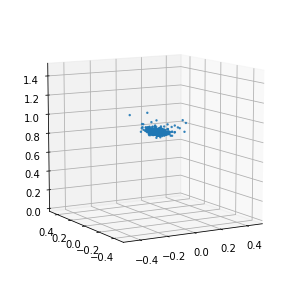

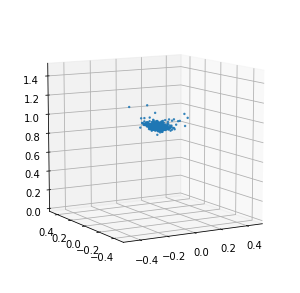

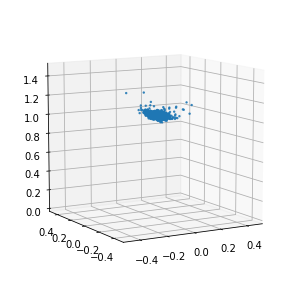

801 (-0.36058473587036133, 0.522234320640564)
802 (-0.33555405139923095, 0.8100250363349915)
803 (-0.24924168288707732, 0.8592413067817688)
804 (-0.358289635181427, 0.7551786303520203)
805 (-0.223666512966156, 0.7246511578559875)
806 (-0.2050812155008316, 0.5073593854904175)
807 (-0.2056390404701233, 0.35441070795059204)
808 (-0.3045994579792023, 0.5494668483734131)
809 (-0.2321418672800064, 0.4835735261440277)
810 (-0.23565827906131745, 0.20743566751480103)
811 (-0.23050523698329925, 0.35394132137298584)
812 (-0.25259906649589536, 0.5384753346443176)
813 (-0.22002958357334138, 0.37469178438186646)
814 (-0.18537644743919374, 0.27528876066207886)
815 (-0.2016770601272583, 0.24699485301971436)
816 (-0.2073538362979889, 0.2496257722377777)
817 (-0.21185536682605743, 0.4363601803779602)
818 (-0.36012703776359556, 0.5052023530006409)
819 (-0.3189589142799377, 0.4998437464237213)
820 (-0.272885400056839, 0.4658184051513672)
821 (-0.2379909873008728, 0.40543219447135925)
822 (-0.2728032797574

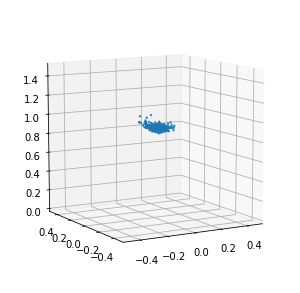

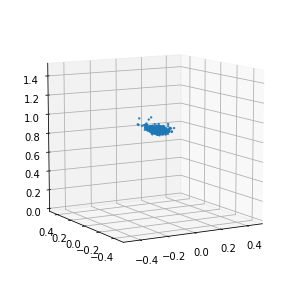

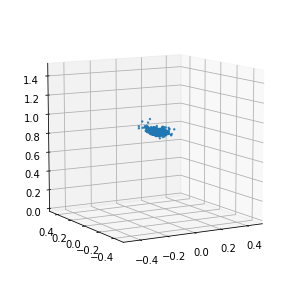

851 (-0.21497690081596374, 0.386402428150177)
852 (-0.18872689604759216, 0.4392423927783966)
853 (-0.2242813378572464, 0.5597094893455505)
854 (-0.2045594036579132, 0.37796249985694885)
855 (-0.24888916015625, 0.32844361662864685)
856 (-0.22605645060539245, 0.4082232713699341)
857 (-0.30899825096130373, 0.3445330858230591)
858 (-0.25535255670547485, 0.18672630190849304)
859 (-0.1808839499950409, 0.280269593000412)
860 (-0.24657482504844666, 0.4007366895675659)
861 (-0.2891117125749588, 0.5271701812744141)
862 (-0.2898830622434616, 0.5262981653213501)
863 (-0.25097266733646395, 0.4565318822860718)
864 (-0.20834679007530213, 0.3827912211418152)
865 (-0.20223987400531768, 0.34196892380714417)
866 (-0.23639629781246185, 0.3105805516242981)
867 (-0.2683040887117386, 0.5357205271720886)
868 (-0.24359878301620483, 0.296309232711792)
869 (-0.2733138859272003, 0.40254703164100647)
870 (-0.27223935425281526, 0.6048195362091064)
871 (-0.2971370816230774, 0.6082258820533752)
872 (-0.29024787545204

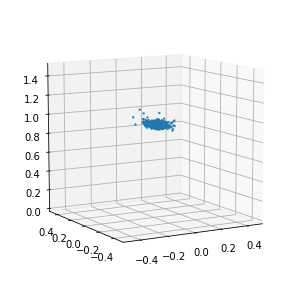

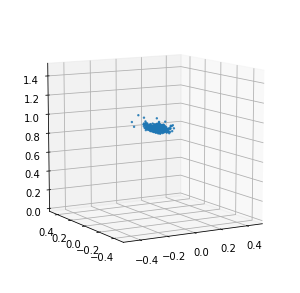

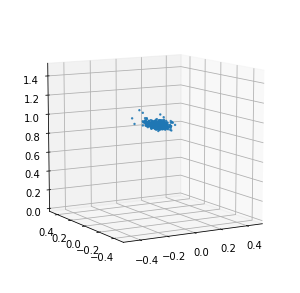

901 (-0.194929039478302, 0.31224676966667175)
902 (-0.3471460998058319, 0.34738871455192566)
903 (-0.27064580619335177, 0.36328360438346863)
904 (-0.3298166573047638, 0.3495006561279297)
905 (-0.28544644117355344, 0.5097691416740417)
906 (-0.27983825504779813, 0.5241715312004089)
907 (-0.2415551871061325, 0.5427351593971252)
908 (-0.18930910527706146, 0.45712170004844666)
909 (-0.19535572528839112, 0.3659259080886841)
910 (-0.12181696891784669, 0.18339648842811584)
911 (-0.23196996450424195, 0.09719478338956833)
912 (-0.3286543726921082, 0.24561172723770142)
913 (-0.34478515982627866, 0.40482234954833984)
914 (-0.32930049300193787, 0.5199756622314453)
915 (-0.29013435244560243, 0.3853420317173004)
916 (-0.2578837454319, 0.4038068652153015)
917 (-0.26274509727954865, 0.3297940790653229)
918 (-0.22837524116039276, 0.3399623930454254)
919 (-0.19265114068984984, 0.32289767265319824)
920 (-0.30037655830383303, 0.34857577085494995)
921 (-0.3868791937828064, 0.3507680892944336)
922 (-0.364187

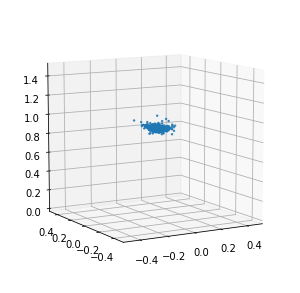

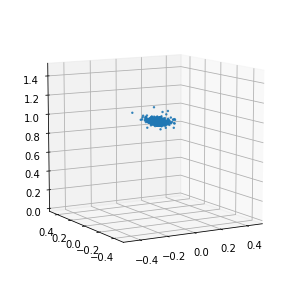

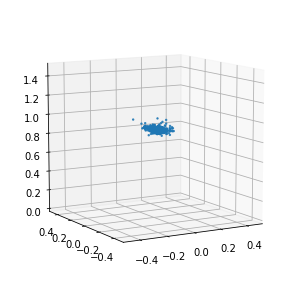

951 (-0.1512184575200081, 0.08073776960372925)
952 (-0.15558471232652665, 0.2107890099287033)
953 (-0.1743835687637329, 0.16098293662071228)
954 (-0.20219137370586396, 0.25643807649612427)
955 (-0.2217945545911789, 0.20450669527053833)
956 (-0.17945506572723388, 0.5261112451553345)
957 (-0.22680338323116303, 0.3861202001571655)
958 (-0.34122570753097536, 0.4280380606651306)
959 (-0.30926700234413146, 0.41205504536628723)
960 (-0.27497119307518003, 0.4132712185382843)
961 (-0.29238374829292296, 0.2908729910850525)
962 (-0.21192483603954315, 0.357904851436615)
963 (-0.26858797669410706, 0.42494964599609375)
964 (-0.3747809410095215, 0.7154091000556946)
965 (-0.35898281931877135, 0.7121037840843201)
966 (-0.2470554769039154, 0.5646504759788513)
967 (-0.24192278385162352, 0.3408464193344116)
968 (-0.232304123044014, 0.26908233761787415)
969 (-0.25951182544231416, 0.3216783106327057)
970 (-0.3270992934703827, 0.44294440746307373)
971 (-0.3094550907611847, 0.2649650573730469)
972 (-0.3175515

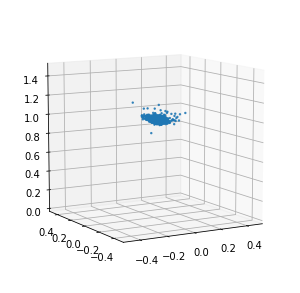

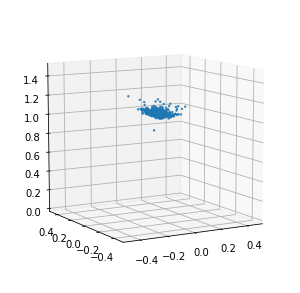

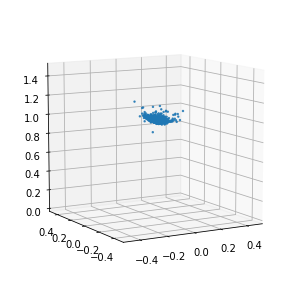

1001 (-0.26135570704936983, 0.5542071461677551)
1002 (-0.29199368953704835, 0.33595332503318787)
1003 (-0.228903928399086, 0.2871943414211273)
1004 (-0.19457192420959474, 0.22598452866077423)
1005 (-0.2361326277256012, 0.2034059762954712)
1006 (-0.18128887712955474, 0.11366165429353714)
1007 (-0.1601110577583313, 0.1507825255393982)
1008 (-0.1565334290266037, 0.16206809878349304)
1009 (-0.17018582224845885, 0.12106332182884216)
1010 (-0.2073010504245758, 0.19045644998550415)
1011 (-0.2639792799949646, 0.1401941329240799)
1012 (-0.19669421017169952, 0.07142489403486252)
1013 (-0.21009202003479005, 0.2935506999492645)
1014 (-0.2140578031539917, 0.36696335673332214)
1015 (-0.14908064901828766, 0.15252260863780975)
1016 (-0.12173649296164513, 0.1944827288389206)
1017 (-0.2680128037929535, 0.1923411786556244)
1018 (-0.2563730955123901, 0.136987566947937)
1019 (-0.24531348645687104, 0.15511709451675415)
1020 (-0.21472957134246826, 0.125707745552063)
1021 (-0.2086158037185669, 0.1688230633735

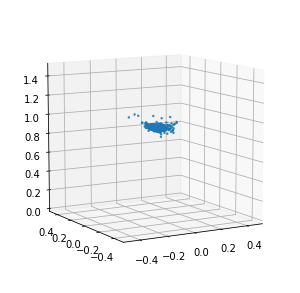

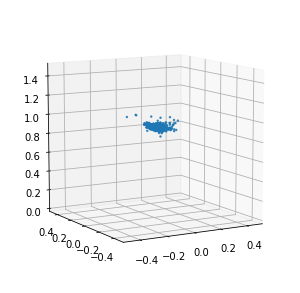

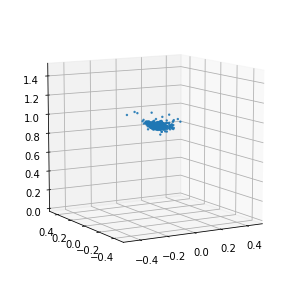

1051 (-0.24154983460903168, 0.13232764601707458)
1052 (-0.2696728318929672, 0.4154292941093445)
1053 (-0.2552678406238556, 0.32607948780059814)
1054 (-0.2903520405292511, 0.22723323106765747)
1055 (-0.34960848093032837, 0.23431526124477386)
1056 (-0.19483458399772643, 0.07489432394504547)
1057 (-0.23903631567955017, 0.20904241502285004)
1058 (-0.20357894897460938, 0.10467830300331116)
1059 (-0.2452689915895462, 0.14091499149799347)
1060 (-0.22819320261478424, 0.03661184385418892)
1061 (-0.22769026160240174, 0.24422630667686462)
1062 (-0.2199550300836563, 0.2553214132785797)
1063 (-0.23070567846298218, 0.21863383054733276)
1064 (-0.23610031306743623, 0.2619645595550537)
1065 (-0.26106388568878175, 0.38717368245124817)
1066 (-0.23425711393356324, 0.13069021701812744)
1067 (-0.2375976949930191, 0.23090913891792297)
1068 (-0.2035243958234787, 0.2644522190093994)
1069 (-0.20069680809974672, 0.1808127909898758)
1070 (-0.19657284319400786, 0.10759031027555466)
1071 (-0.26528475880622865, 0.11

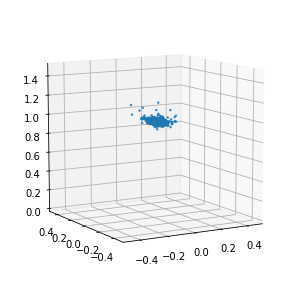

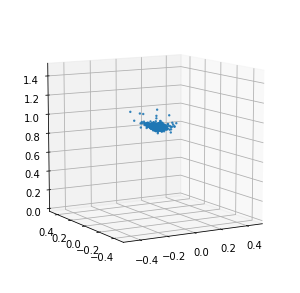

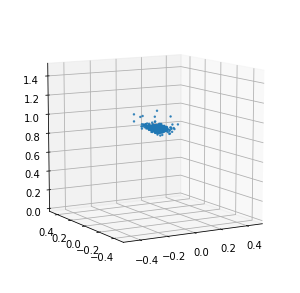

1101 (-0.31160608530044553, 0.42030543088912964)
1102 (-0.16578863859176635, 0.22065018117427826)
1103 (-0.13415711522102355, 0.06393051892518997)
1104 (-0.23780024349689483, -0.008558657020330429)
1105 (-0.24335658848285674, -0.018789159134030342)
1106 (-0.29440596103668215, -0.003272147849202156)
1107 (-0.20789631009101867, -0.10408703982830048)
1108 (-0.18966111838817595, -0.055973321199417114)
1109 (-0.15788743495941163, 0.06163274124264717)
1110 (-0.22826097905635834, 0.18680347502231598)
1111 (-0.24900634586811066, 0.23101480305194855)
1112 (-0.2486114352941513, 0.16228221356868744)
1113 (-0.3463275611400604, 0.10370142012834549)
1114 (-0.1976635903120041, 0.05944519862532616)
1115 (-0.2515585541725159, 0.15322011709213257)
1116 (-0.2823575884103775, 0.08642908185720444)
1117 (-0.20102579295635223, 0.1926739513874054)
1118 (-0.25366802513599396, 0.3297402560710907)
1119 (-0.19436180889606475, 0.17792381346225739)
1120 (-0.1376391291618347, 0.021017231047153473)
1121 (-0.238975012

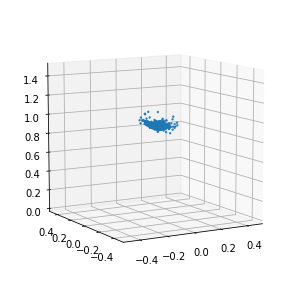

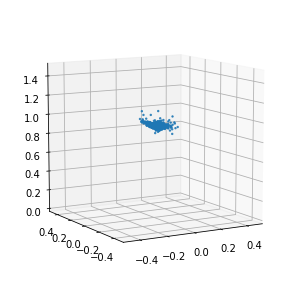

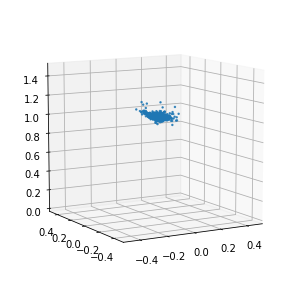

1151 (-0.1945689857006073, 0.024655580520629883)
1152 (-0.1725040465593338, -0.004459805320948362)
1153 (-0.2072933167219162, -0.04863153025507927)
1154 (-0.22394137978553771, -0.18516607582569122)
1155 (-0.16327421069145204, 0.0010257386602461338)
1156 (-0.25536568760871886, 0.1377776712179184)
1157 (-0.19132107198238374, 0.18367785215377808)
1158 (-0.2786109924316406, 0.3173958659172058)
1159 (-0.2754549145698547, 0.3583962619304657)
1160 (-0.21951765120029448, 0.32141703367233276)
1161 (-0.20371797382831575, 0.2300424724817276)
1162 (-0.23971491158008576, 0.15933477878570557)
1163 (-0.19972499012947081, 0.14802978932857513)
1164 (-0.2514842629432678, 0.20216017961502075)
1165 (-0.19163423478603364, 0.2088688611984253)
1166 (-0.15427647531032562, 0.05379796400666237)
1167 (-0.15320067405700682, -0.0858558714389801)
1168 (-0.18122252225875854, -0.049874447286129)
1169 (-0.2136802315711975, 0.011005773209035397)
1170 (-0.24901941120624543, 0.017921704798936844)
1171 (-0.204588636755943

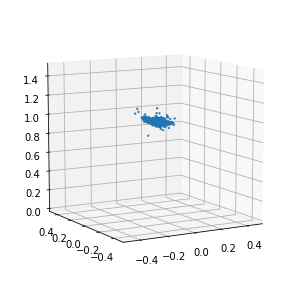

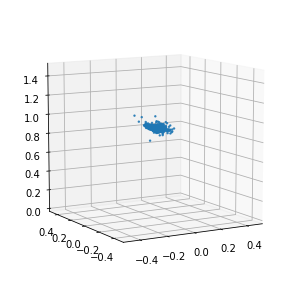

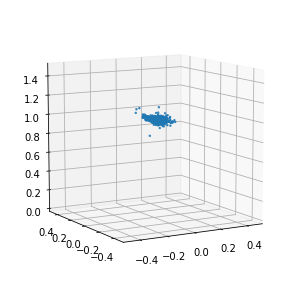

1201 (-0.1114757627248764, 0.3641209900379181)
1202 (-0.1868317484855652, 0.1363106220960617)
1203 (-0.31031650900840757, 0.41139161586761475)
1204 (-0.3554344892501831, 0.3438597023487091)
1205 (-0.3937333822250366, 0.4489419460296631)
1206 (-0.3687171220779419, 0.4691297113895416)
1207 (-0.3095272719860077, 0.5604223608970642)
1208 (-0.2462650418281555, 0.6684128046035767)
1209 (-0.2920080184936523, 0.5450370907783508)
1210 (-0.28890838623046877, 0.39133140444755554)
1211 (-0.2892685174942017, 0.37800097465515137)
1212 (-0.18476480841636658, 0.19194717705249786)
1213 (-0.22252903878688812, 0.09085460007190704)
1214 (-0.2636280030012131, 0.05415533110499382)
1215 (-0.22224898338317872, 0.23887458443641663)
1216 (-0.2974216163158417, 0.34537559747695923)
1217 (-0.27181890308856965, 0.15505248308181763)
1218 (-0.352869912981987, 0.5989629030227661)
1219 (-0.2029150128364563, 0.316956490278244)
1220 (-0.21374375224113465, 0.12552116811275482)
1221 (-0.27339888215065, 0.328177809715271)
1

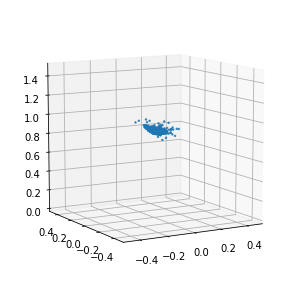

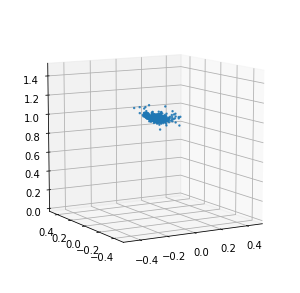

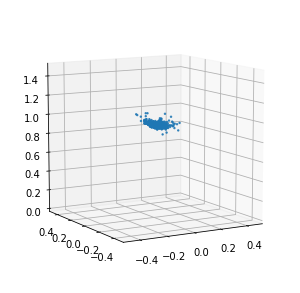

1251 (-0.14731965512037276, 0.08259307593107224)
1252 (-0.17200614809989928, 0.1207042708992958)
1253 (-0.22091937065124512, 0.08790268003940582)
1254 (-0.1447017639875412, -0.0022347443737089634)
1255 (-0.17512743473052977, 0.003977733664214611)
1256 (-0.15273857414722442, -0.11380290985107422)
1257 (-0.11675644367933273, -0.1819474995136261)
1258 (-0.1678915172815323, -0.11733832955360413)
1259 (-0.22715354859828948, -0.06522257626056671)
1260 (-0.1691482573747635, -0.06292282044887543)
1261 (-0.19885404109954835, 0.017404034733772278)
1262 (-0.16570853888988496, 0.013780233450233936)
1263 (-0.1527837783098221, 0.10122831165790558)
1264 (-0.15341150462627412, 0.0026645255275070667)
1265 (-0.14981555938720703, 0.09632807970046997)
1266 (-0.14470962285995484, -0.05150797963142395)
1267 (-0.16089023053646087, -0.03083936683833599)
1268 (-0.21827563047409057, 0.08746542781591415)
1269 (-0.19105870127677918, 0.17391642928123474)
1270 (-0.15351023226976396, 0.11669452488422394)
1271 (-0.14

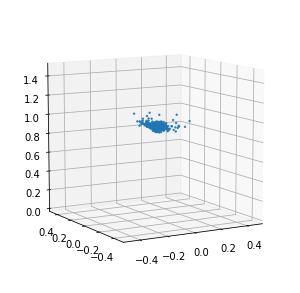

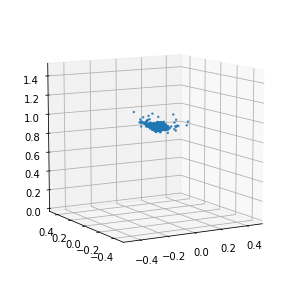

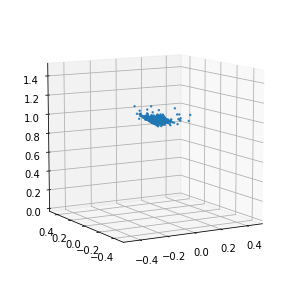

1301 (-0.273637256026268, 0.2196027785539627)
1302 (-0.20637872517108918, 0.15096208453178406)
1303 (-0.19800090193748474, 0.1651833951473236)
1304 (-0.16981226503849028, 0.2556113600730896)
1305 (-0.1617448389530182, 0.24142880737781525)
1306 (-0.17336181104183196, 0.15160468220710754)
1307 (-0.1610426723957062, -0.012407255358994007)
1308 (-0.14576662182807923, 0.05043405666947365)
1309 (-0.22934738099575042, 0.02791188284754753)
1310 (-0.1548469752073288, -0.1644706130027771)
1311 (-0.20320474803447724, 0.09705499559640884)
1312 (-0.13748449981212615, 0.16347666084766388)
1313 (-0.14278985410928727, -0.009615215472877026)
1314 (-0.16063372194766998, 0.0012415576493367553)
1315 (-0.18124131560325624, 0.07018861919641495)
1316 (-0.10727339386940002, -0.10271049290895462)
1317 (-0.16056864857673644, -0.28179559111595154)
1318 (-0.3006144255399704, -0.1688014566898346)
1319 (-0.19383973777294158, -0.15381194651126862)
1320 (-0.2352478802204132, -0.20458781719207764)
1321 (-0.19654591083

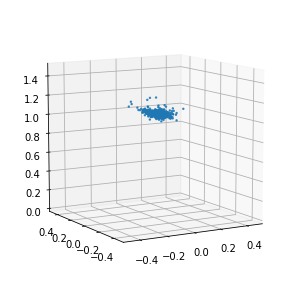

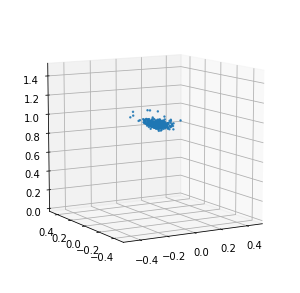

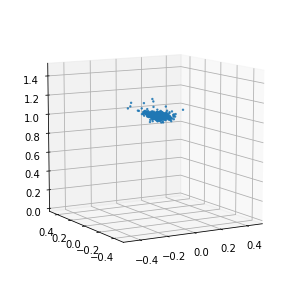

1351 (-0.18829415887594222, 0.003763980232179165)
1352 (-0.18449549078941346, 0.029292361810803413)
1353 (-0.19821642339229584, -0.006602210458368063)
1354 (-0.18937911987304687, 0.06230977177619934)
1355 (-0.25633483529090884, 0.1495363861322403)
1356 (-0.15993044674396514, -0.025797341018915176)
1357 (-0.1431750848889351, -0.13825447857379913)
1358 (-0.16518603563308715, -0.08984953910112381)
1359 (-0.2684338390827179, 0.001319058588705957)
1360 (-0.20149506330490113, 0.12421709299087524)
1361 (-0.1879648208618164, 0.07251282036304474)
1362 (-0.1514839142560959, 0.161127969622612)
1363 (-0.21303362846374513, 0.043610621243715286)
1364 (-0.18398527801036835, 0.029534779489040375)
1365 (-0.16794258803129197, 0.09259527921676636)
1366 (-0.1612668514251709, -0.1006200760602951)
1367 (-0.1479459971189499, -0.22046932578086853)
1368 (-0.14846205711364746, -0.2427569180727005)
1369 (-0.20026181042194366, -0.04364461079239845)
1370 (-0.31101601719856264, -0.07857942581176758)
1371 (-0.162492

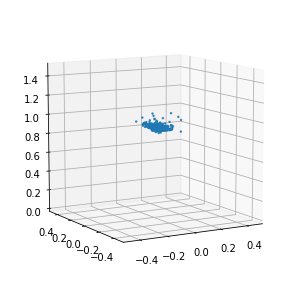

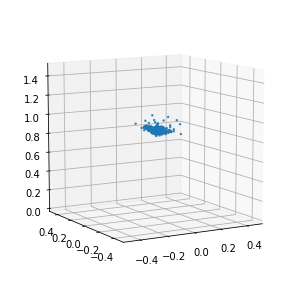

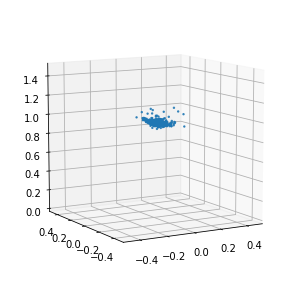

1401 (-0.25235278606414796, 0.21049106121063232)
1402 (-0.2671323776245117, 0.25880029797554016)
1403 (-0.263456791639328, 0.2686496376991272)
1404 (-0.22223562896251678, 0.09051364660263062)
1405 (-0.2376369833946228, 0.04509799927473068)
1406 (-0.19392439126968383, 0.062294092029333115)
1407 (-0.1444324627518654, -0.04002339020371437)
1408 (-0.17178490459918977, 0.05081824213266373)
1409 (-0.18890229016542434, -0.06637494266033173)
1410 (-0.12845562398433685, -0.0993768498301506)
1411 (-0.15545939803123474, -0.08738075196743011)
1412 (-0.14250219017267227, -0.08413805067539215)
1413 (-0.17017050534486772, -5.187630813452415e-05)
1414 (-0.17088214606046676, 0.027970947325229645)
1415 (-0.16376615762710572, 0.07085511833429337)
1416 (-0.20378739535808563, 0.12212643772363663)
1417 (-0.1876780241727829, 0.06875377148389816)
1418 (-0.15543330907821656, -0.05965737998485565)
1419 (-0.1878380686044693, -0.09530825912952423)
1420 (-0.18593948781490327, -0.10044040530920029)
1421 (-0.1703075

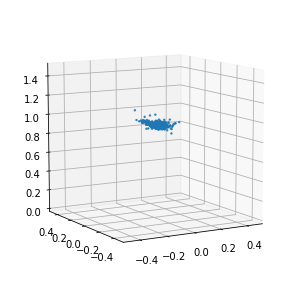

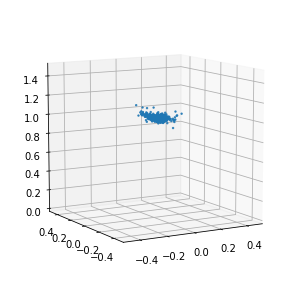

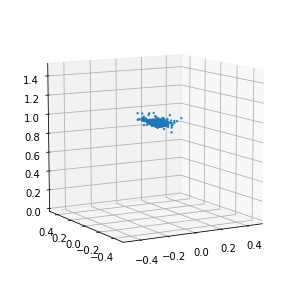

1451 (-0.15594942271709442, -0.028500664979219437)
1452 (-0.15308777689933778, -0.05482831597328186)
1453 (-0.18910754919052125, 0.0744994655251503)
1454 (-0.14457712024450303, 0.028432201594114304)
1455 (-0.1648903638124466, 0.11364783346652985)
1456 (-0.1438702642917633, 0.1863296926021576)
1457 (-0.14099551886320114, -0.01267837081104517)
1458 (-0.13167974203824998, -0.07383787631988525)
1459 (-0.10314427167177201, -0.006946501787751913)
1460 (-0.1342930868268013, -0.09609733521938324)
1461 (-0.20190491676330566, -0.15442407131195068)
1462 (-0.2067225992679596, -0.08970391005277634)
1463 (-0.1720482140779495, -0.04028613492846489)
1464 (-0.16658721268177032, 0.013173138722777367)
1465 (-0.10812325477600097, 0.029082627967000008)
1466 (-0.1421855330467224, -0.07596907764673233)
1467 (-0.18984634280204774, -0.1329900026321411)
1468 (-0.19347304105758667, -0.022001033648848534)
1469 (-0.20195620656013488, -0.06291710585355759)
1470 (-0.21330348253250123, -0.04179377481341362)
1471 (-0.

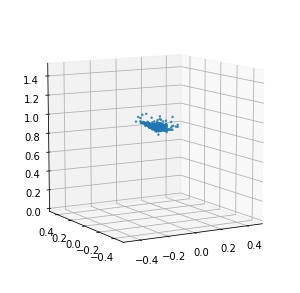

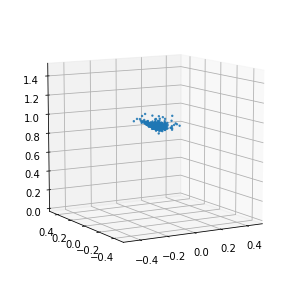

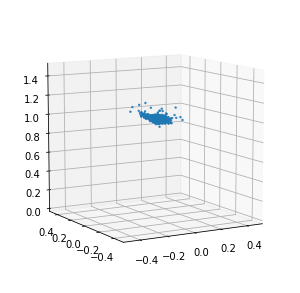

1501 (-0.19380946159362794, -0.026931414380669594)
1502 (-0.1710114896297455, -0.009883030317723751)
1503 (-0.15824351608753204, 0.11648236215114594)
1504 (-0.1704322636127472, 0.11105817556381226)
1505 (-0.18191458880901337, 0.13289372622966766)
1506 (-0.1801200971007347, -0.030217381194233894)
1507 (-0.1829569309949875, 0.01919729635119438)
1508 (-0.1660371333360672, 0.11682209372520447)
1509 (-0.1378897413611412, 0.019437745213508606)
1510 (-0.16134620755910872, 0.047614049166440964)
1511 (-0.15104530602693558, -0.04103436321020126)
1512 (-0.14053494930267335, -0.1598844677209854)
1513 (-0.22767424285411836, 0.0504361055791378)
1514 (-0.18113648891448975, -0.0032674772664904594)
1515 (-0.1627102389931679, -0.04779469966888428)
1516 (-0.16178296208381654, -0.03835831582546234)
1517 (-0.19269469976425171, 0.07574091851711273)
1518 (-0.11862404644489288, -0.1310678869485855)
1519 (-0.11899269670248032, 0.012771065346896648)
1520 (-0.09370047450065613, -0.014372718520462513)
1521 (-0.20

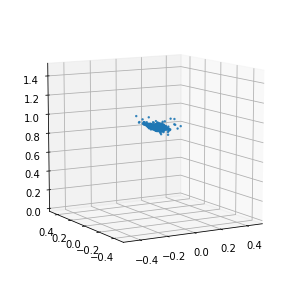

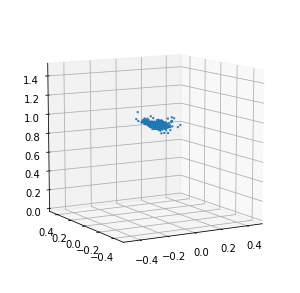

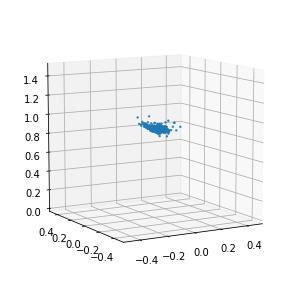

1551 (-0.20486881732940673, 0.013135123066604137)
1552 (-0.14090779274702073, -0.004413650371134281)
1553 (-0.17725526988506318, 0.015307832509279251)
1554 (-0.16313494145870208, -0.04434901103377342)
1555 (-0.16971439123153687, -0.09647297114133835)
1556 (-0.15468040704727173, -0.07594998180866241)
1557 (-0.18585073351860046, -0.12763690948486328)
1558 (-0.1605018347501755, -0.02984517626464367)
1559 (-0.17273667454719543, 0.12042360007762909)
1560 (-0.21006596386432647, 0.01439808402210474)
1561 (-0.18132970631122589, 0.009470101445913315)
1562 (-0.1686191588640213, 0.11120490729808807)
1563 (-0.1703184127807617, 0.14623484015464783)
1564 (-0.2343515247106552, 0.09577159583568573)
1565 (-0.19415559768676757, 0.07535239309072495)
1566 (-0.1483289048075676, -0.056860338896512985)
1567 (-0.12740042060613632, 0.17137914896011353)
1568 (-0.12776932269334793, -0.03553823009133339)
1569 (-0.14474857449531556, -0.041786376386880875)
1570 (-0.1791369467973709, 0.03534496948122978)
1571 (-0.17

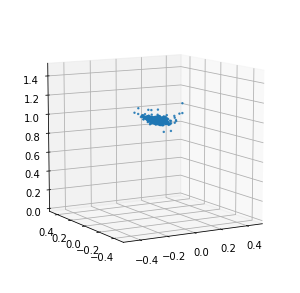

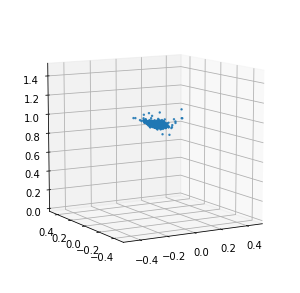

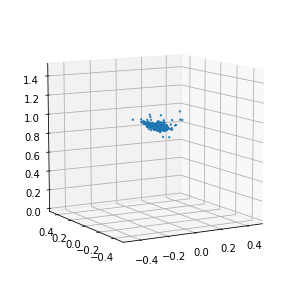

1601 (-0.2215838074684143, 0.19609573483467102)
1602 (-0.20154430866241455, 0.19546425342559814)
1603 (-0.1365814685821533, 0.08324014395475388)
1604 (-0.14491479694843293, 0.14030171930789948)
1605 (-0.12016351670026779, 0.09272889792919159)
1606 (-0.12721384316682816, 0.1434122771024704)
1607 (-0.1289493590593338, 0.11047817021608353)
1608 (-0.13638017922639847, 0.09371113777160645)
1609 (-0.1374491959810257, -0.039666272699832916)
1610 (-0.15179353058338166, -0.048031698912382126)
1611 (-0.1698314666748047, -0.0714496374130249)
1612 (-0.1925399661064148, -0.030943918973207474)
1613 (-0.14390041828155517, -0.002612052019685507)
1614 (-0.07481484711170197, 0.08402838557958603)
1615 (-0.11230582594871522, -0.025099016726017)
1616 (-0.1550555944442749, -0.012598836794495583)
1617 (-0.18847974240779877, 0.07118654996156693)
1618 (-0.25379498600959777, 0.19530002772808075)
1619 (-0.17122594118118287, 0.004100869409739971)
1620 (-0.16072973012924194, -0.13602785766124725)
1621 (-0.24084856

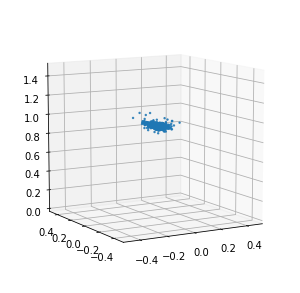

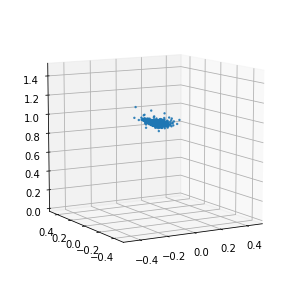

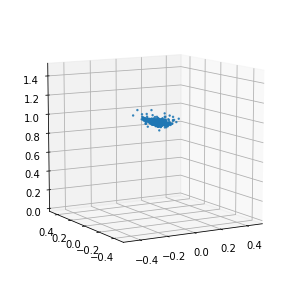

1651 (-0.20207589864730835, 0.269917756319046)
1652 (-0.15564575493335725, 0.3768833875656128)
1653 (-0.09596399366855621, 0.12185493111610413)
1654 (-0.09859414547681808, 0.005798904690891504)
1655 (-0.10797580629587174, -0.08525393158197403)
1656 (-0.14048611521720886, 0.022633852437138557)
1657 (-0.14483577162027358, 0.08560363948345184)
1658 (-0.1548237144947052, 0.06705652177333832)
1659 (-0.13713929802179337, 0.0008937832899391651)
1660 (-0.11332816034555435, -0.05438288301229477)
1661 (-0.15454863905906677, -0.022961555048823357)
1662 (-0.13442000150680541, -0.04835370182991028)
1663 (-0.163500839471817, -0.037838131189346313)
1664 (-0.14712437987327576, -0.02038256637752056)
1665 (-0.12620602548122406, 0.06289813667535782)
1666 (-0.1537519484758377, -0.06379420310258865)
1667 (-0.14200404286384583, -0.21919898688793182)
1668 (-0.13204658031463623, -0.09664800763130188)
1669 (-0.2440768599510193, 0.22859369218349457)
1670 (-0.11590117812156678, 0.09309571236371994)
1671 (-0.1654

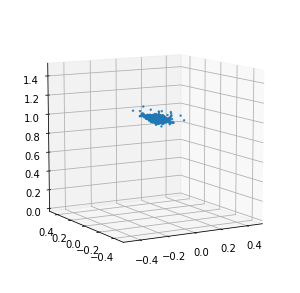

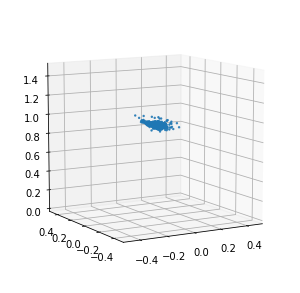

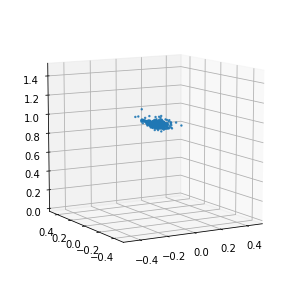

1701 (-0.14215759187936783, -0.14296291768550873)
1702 (-0.14620157778263093, -0.1357719451189041)
1703 (-0.10651601105928421, -0.005127565935254097)
1704 (-0.11298917680978775, -0.12819647789001465)
1705 (-0.06871000230312348, -0.15376786887645721)
1706 (-0.10137785226106644, -0.1329219937324524)
1707 (-0.09631307572126388, -0.16226966679096222)
1708 (-0.10891847312450409, -0.14817769825458527)
1709 (-0.10701890140771866, -0.27741318941116333)
1710 (-0.1194782704114914, -0.19400537014007568)
1711 (-0.10876581370830536, -0.042078763246536255)
1712 (-0.16392110884189606, 0.0052342163398861885)
1713 (-0.15211838185787202, -0.0154033824801445)
1714 (-0.18699510395526886, -0.0062732757069170475)
1715 (-0.14974991381168365, 0.09206564724445343)
1716 (-0.1670038342475891, 0.11092626303434372)
1717 (-0.1259898215532303, -0.031915534287691116)
1718 (-0.12133748531341552, -0.07396488636732101)
1719 (-0.10292387306690216, -0.10683146119117737)
1720 (-0.1784302294254303, -0.09107105433940887)
172

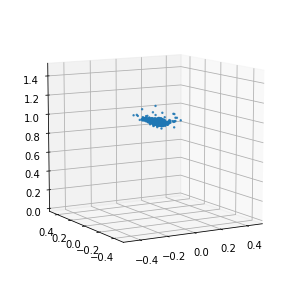

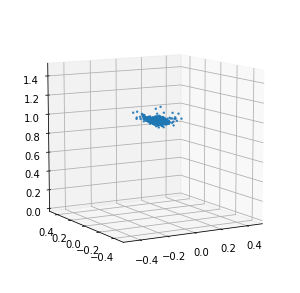

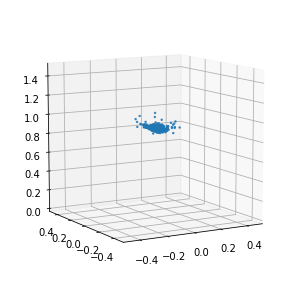

1751 (-0.16977384090423583, -0.05998862162232399)
1752 (-0.16096835732460021, -0.009153715334832668)
1753 (-0.15745177268981933, 0.025564007461071014)
1754 (-0.14963871836662293, 0.08234710991382599)
1755 (-0.1674601823091507, 0.09336499124765396)
1756 (-0.16336653232574463, 0.042123083025217056)
1757 (-0.15033834874629975, -0.03945676609873772)
1758 (-0.22581802010536195, 0.14445139467716217)
1759 (-0.10521930307149888, 0.023321986198425293)
1760 (-0.11271424442529679, 0.04047437757253647)
1761 (-0.10223861187696456, 0.02592611499130726)
1762 (-0.10115202367305756, -0.041110195219516754)
1763 (-0.10393331944942474, 0.013133457861840725)
1764 (-0.11425395756959915, -0.07104767113924026)
1765 (-0.14061792492866515, -0.04021115601062775)
1766 (-0.24754419028759003, 0.1460745483636856)
1767 (-0.25127512216567993, 0.10974179208278656)
1768 (-0.1466675043106079, 0.18535499274730682)
1769 (-0.148005647957325, 0.15317277610301971)
1770 (-0.11257548779249191, -0.03661395609378815)
1771 (-0.132

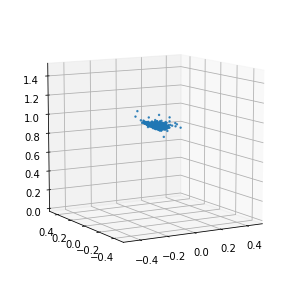

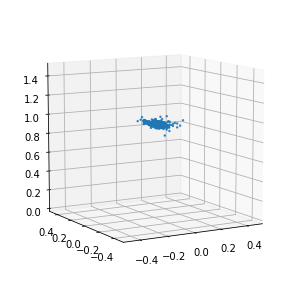

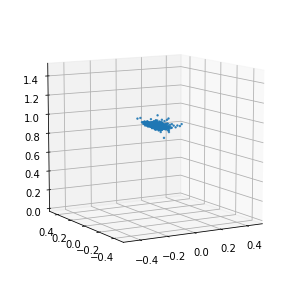

1801 (-0.1308615043759346, -0.12573407590389252)
1802 (-0.10170426070690156, -0.18516987562179565)
1803 (-0.13537031710147857, -0.1603657603263855)
1804 (-0.10025949776172638, -0.0819624811410904)
1805 (-0.124998340010643, -0.16767507791519165)
1806 (-0.17905991971492768, -0.16988176107406616)
1807 (-0.14236911982297898, 0.042274583131074905)
1808 (-0.1251664638519287, 0.021113039925694466)
1809 (-0.14277787506580353, 0.15402761101722717)
1810 (-0.11933626085519791, 0.10364068299531937)
1811 (-0.20273977816104888, 0.055542122572660446)
1812 (-0.1647385761141777, -0.010710315778851509)
1813 (-0.17613041549921035, 0.03065044805407524)
1814 (-0.17223892211914063, 0.08791862428188324)
1815 (-0.17827954292297363, 0.0492330938577652)
1816 (-0.1328212782740593, -0.011356114409863949)
1817 (-0.12767670750617982, -0.08566291630268097)
1818 (-0.108793905377388, 0.020650839433073997)
1819 (-0.14606829285621642, 0.0002520427224226296)
1820 (-0.10784199386835099, -0.11217989027500153)
1821 (-0.0905

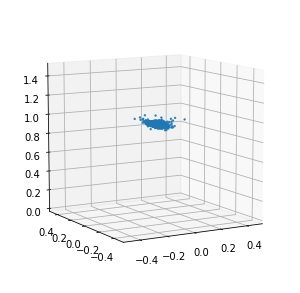

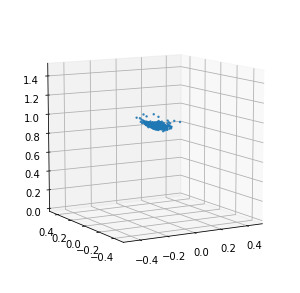

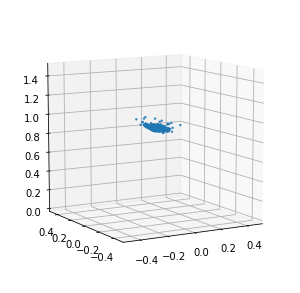

1851 (-0.11436030715703964, -0.130437970161438)
1852 (-0.10141987353563309, -0.12805476784706116)
1853 (-0.10817664265632629, -0.27031898498535156)
1854 (-0.12312816977500915, -0.21626368165016174)
1855 (-0.11023986786603927, -0.2805180251598358)
1856 (-0.13707057535648345, -0.2184482365846634)
1857 (-0.14913420081138612, -0.2163674682378769)
1858 (-0.1051494225859642, -0.12817741930484772)
1859 (-0.11567357331514358, -0.1568322628736496)
1860 (-0.1573280155658722, -0.08432206511497498)
1861 (-0.23692900240421294, 0.14804622530937195)
1862 (-0.11827460825443267, -0.015638653188943863)
1863 (-0.10913970619440079, -0.08636386692523956)
1864 (-0.1105363517999649, -0.011476521380245686)
1865 (-0.10171410888433456, -0.014913585036993027)
1866 (-0.15052260607481002, -0.01771519146859646)
1867 (-0.138086299598217, -0.0627560168504715)
1868 (-0.14329853951931, 0.008295869454741478)
1869 (-0.13368713855743408, 0.012583642266690731)
1870 (-0.12276791930198669, -0.10501657426357269)
1871 (-0.1470

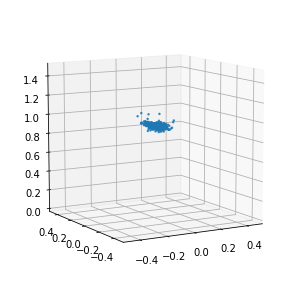

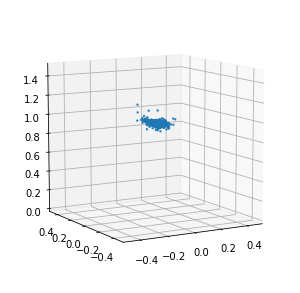

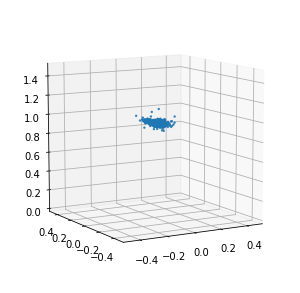

1901 (-0.15871728211641312, -0.11830182373523712)
1902 (-0.1493845373392105, -0.205815851688385)
1903 (-0.16902239322662355, -0.12155380100011826)
1904 (-0.15278215259313582, 0.05654902756214142)
1905 (-0.19808783531188964, 0.061846744269132614)
1906 (-0.16823988854885102, 0.10919125378131866)
1907 (-0.14832794964313506, 0.13223901391029358)
1908 (-0.11794299334287643, 0.015730643644928932)
1909 (-0.12013075053691864, 0.0065193758346140385)
1910 (-0.13464206010103225, 0.033367421478033066)
1911 (-0.11710617840290069, -0.052287861704826355)
1912 (-0.10095557123422623, -0.08529982715845108)
1913 (-0.12488142997026444, -0.028554508462548256)
1914 (-0.13282217383384703, -0.07360869646072388)
1915 (-0.10694313943386077, -0.07312054932117462)
1916 (-0.12903204560279846, -0.11627742648124695)
1917 (-0.14077998846769332, -0.13773974776268005)
1918 (-0.11122091710567475, -0.07107521593570709)
1919 (-0.1679277539253235, -0.057745542377233505)
1920 (-0.10700587928295135, -0.05010196566581726)
192

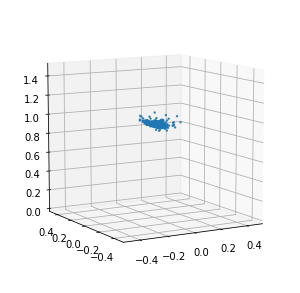

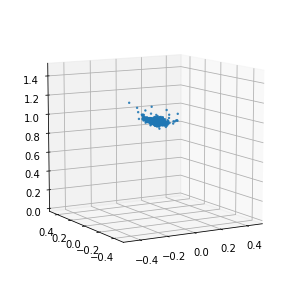

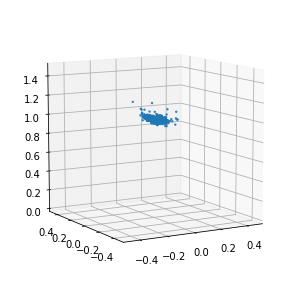

1951 (-0.19549569487571716, 0.036782171577215195)
1952 (-0.1490564227104187, -0.03459809347987175)
1953 (-0.18914948999881745, -0.07264099270105362)
1954 (-0.1534849300980568, 0.018453547731041908)
1955 (-0.11410861015319824, -0.018837548792362213)
1956 (-0.11486141085624695, 0.08355652540922165)
1957 (-0.0722645178437233, -0.0009413145598955452)
1958 (-0.13529113829135894, -0.021994106471538544)
1959 (-0.12783890664577485, -0.050485946238040924)
1960 (-0.12803404927253723, -0.1672196388244629)
1961 (-0.11168320178985595, -0.11936237663030624)
1962 (-0.1105178102850914, -0.218673974275589)
1963 (-0.21365846395492555, -0.0691865086555481)
1964 (-0.10900861471891403, -0.12246578186750412)
1965 (-0.11524685472249985, -0.15504366159439087)
1966 (-0.1278418630361557, -0.1427333950996399)
1967 (-0.12266010642051697, -0.14412163197994232)
1968 (-0.13438323736190796, -0.0544515885412693)
1969 (-0.13065088987350465, -0.08725548535585403)
1970 (-0.19174058139324188, 0.055840179324150085)
1971 (-

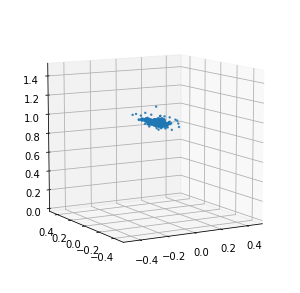

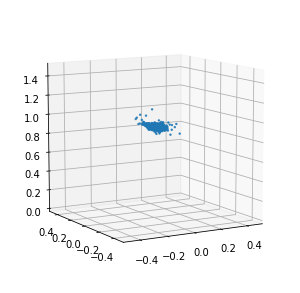

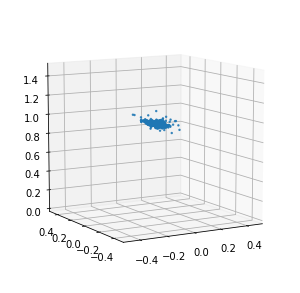

2001 (-0.17986607253551484, 0.012878019362688065)
2002 (-0.11881930828094482, -0.001523304614238441)
2003 (-0.13960792422294616, 0.03712090104818344)
2004 (-0.1134916976094246, 0.004476281814277172)
2005 (-0.11561789810657501, 0.13041463494300842)
2006 (-0.15079113095998764, 0.061331819742918015)
2007 (-0.11331136524677277, -0.04712612181901932)
2008 (-0.24316914081573487, 0.20509660243988037)
2009 (-0.08533863127231597, 0.018880318850278854)
2010 (-0.19595100730657578, 0.11056557297706604)
2011 (-0.15554307997226716, 0.1143774762749672)
2012 (-0.08370025753974915, -0.060265980660915375)
2013 (-0.0720861479640007, -0.10929790139198303)
2014 (-0.08003185838460922, -0.11920301616191864)
2015 (-0.07265989780426026, -0.16635733842849731)
2016 (-0.1156946748495102, -0.1623503863811493)
2017 (-0.14389225244522094, -0.1576259285211563)
2018 (-0.12488475441932678, -0.07535476982593536)
2019 (-0.07420293539762497, -0.016268406063318253)
2020 (-0.1391180709004402, -0.2070673406124115)
2021 (-0.1

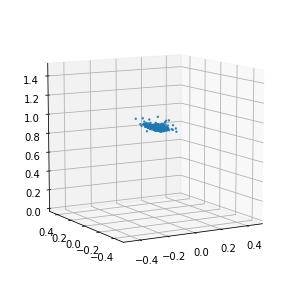

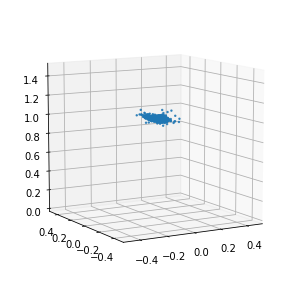

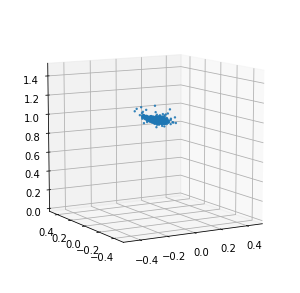

2051 (-0.10160759687423707, -0.06549569219350815)
2052 (-0.09847268164157867, -0.1377788782119751)
2053 (-0.11547160148620605, -0.23923465609550476)
2054 (-0.1102170929312706, -0.19716720283031464)
2055 (-0.12070401310920716, -0.16118723154067993)
2056 (-0.14160065203905106, -0.011244798079133034)
2057 (-0.11043146550655365, 0.08794888854026794)
2058 (-0.1287533849477768, -0.06772011518478394)
2059 (-0.12273644804954528, -0.038015253841876984)
2060 (-0.1460659459233284, 0.004840008914470673)
2061 (-0.11336481422185898, -0.007540172431617975)
2062 (-0.11032287329435349, -0.06868606805801392)
2063 (-0.08322966545820236, -0.18313910067081451)
2064 (-0.15402202755212785, -0.155616894364357)
2065 (-0.11229954063892364, -0.12152215838432312)
2066 (-0.10596364289522171, -0.1718282699584961)
2067 (-0.11256428062915802, -0.18593506515026093)
2068 (-0.22593091428279877, -0.140875443816185)
2069 (-0.12001164704561233, -0.23782150447368622)
2070 (-0.07162698656320572, -0.10931099206209183)
2071 (-

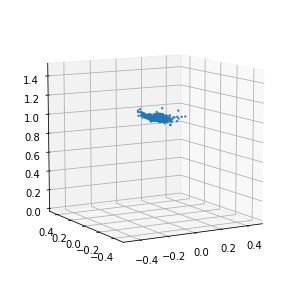

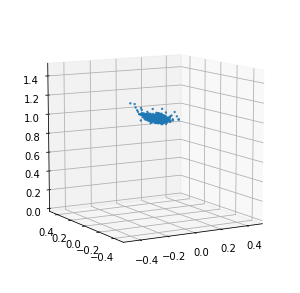

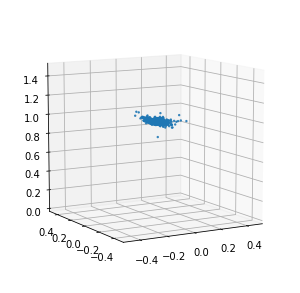

2101 (-0.09898939728736877, -0.10705587267875671)
2102 (-0.07533608675003052, -0.1135232150554657)
2103 (-0.09107220023870469, -0.20879457890987396)
2104 (-0.09131885766983032, -0.10985023528337479)
2105 (-0.08279156535863877, -0.2099274843931198)
2106 (-0.0839180439710617, -0.2559157609939575)
2107 (-0.07927757054567337, -0.2025536149740219)
2108 (-0.0934727892279625, -0.11418499052524567)
2109 (-0.13426486253738404, 0.05035482347011566)
2110 (-0.14876042753458024, 0.024964001029729843)
2111 (-0.17983462810516357, 0.010439530946314335)
2112 (-0.16405007243156433, 0.23591764271259308)
2113 (-0.14949711114168168, 0.19570086896419525)
2114 (-0.12189697772264481, -0.013295697048306465)
2115 (-0.11310969144105912, -0.03845668584108353)
2116 (-0.1212935745716095, -0.10022816061973572)
2117 (-0.14110140651464462, 0.003350152401253581)
2118 (-0.11898219287395477, 0.013358104974031448)
2119 (-0.09752314537763596, 0.042335107922554016)
2120 (-0.15457942634820937, 0.10586582124233246)
2121 (-0.0

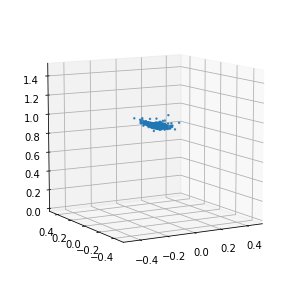

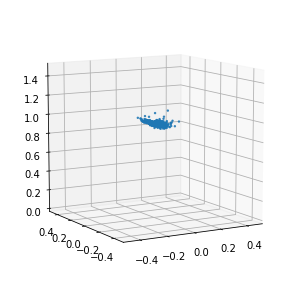

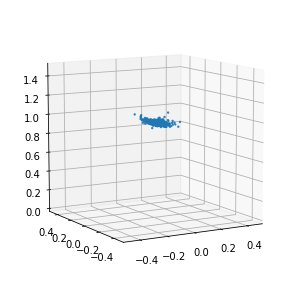

2151 (-0.09481203258037567, -0.07727797329425812)
2152 (-0.09559030681848527, -0.018118197098374367)
2153 (-0.07344160377979278, -0.09320595860481262)
2154 (-0.13638322949409484, -0.05831031873822212)
2155 (-0.07906730324029923, -0.16178005933761597)
2156 (-0.07878211438655854, -0.20377254486083984)
2157 (-0.20700673162937164, -0.039281245321035385)
2158 (-0.08672761917114258, 0.03831692785024643)
2159 (-0.0893936350941658, -0.06667924672365189)
2160 (-0.08485331684350968, -0.1883213073015213)
2161 (-0.09079026728868485, -0.09925028681755066)
2162 (-0.08774791210889817, -0.08559466153383255)
2163 (-0.09991964995861054, -0.02848462387919426)
2164 (-0.08742340207099915, -0.06265948712825775)
2165 (-0.11076161563396454, -0.07196811586618423)
2166 (-0.08803278803825379, 0.13028164207935333)
2167 (-0.11183682978153228, 0.12840871512889862)
2168 (-0.14833071678876877, 0.010655459947884083)
2169 (-0.09678567796945572, -0.058656591922044754)
2170 (-0.08610899597406388, -0.017070716246962547)
2

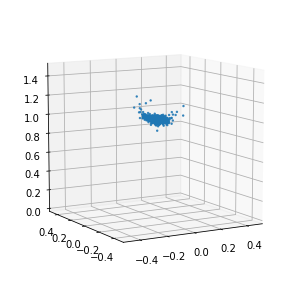

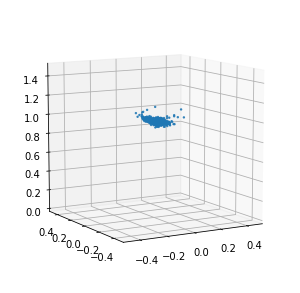

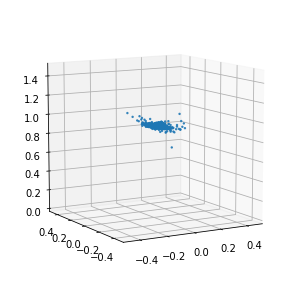

2201 (-0.14826907813549042, 0.03338959813117981)
2202 (-0.14679004997015, 0.061400119215250015)
2203 (-0.11721525490283966, -0.0231891218572855)
2204 (-0.12841704189777375, -0.01160102616995573)
2205 (-0.08458555936813354, -0.04479274898767471)
2206 (-0.1272326797246933, -0.0770169049501419)
2207 (-0.11683914661407471, -0.041728679090738297)
2208 (-0.17381623089313508, 0.07348804175853729)
2209 (-0.13679553419351578, 0.07502225786447525)
2210 (-0.07503215223550797, -0.01469702459871769)
2211 (-0.10060572326183319, 0.12719066441059113)
2212 (-0.11543352305889129, 0.15296272933483124)
2213 (-0.14387511014938353, 0.084172822535038)
2214 (-0.12559079378843307, 0.06192149966955185)
2215 (-0.12615262269973754, 0.007132974453270435)
2216 (-0.08180788010358811, -0.045774683356285095)
2217 (-0.0620897650718689, -0.12255046516656876)
2218 (-0.08060219585895538, -0.12263276427984238)
2219 (-0.07355348318815232, -0.09557775408029556)
2220 (-0.08181797116994857, -0.18470479547977448)
2221 (-0.08354

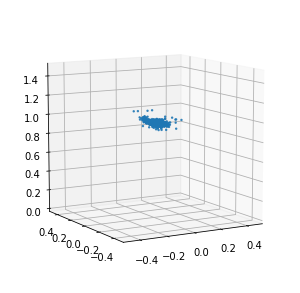

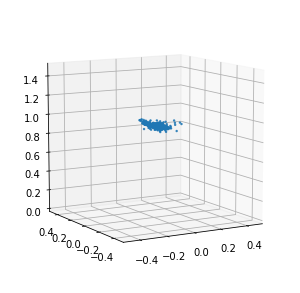

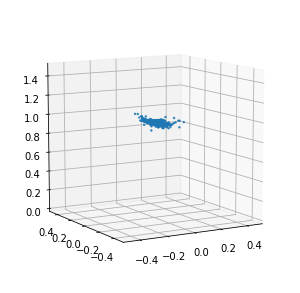

2251 (-0.10907283872365951, -0.08788082003593445)
2252 (-0.10214578658342362, 0.03108246810734272)
2253 (-0.1402692437171936, -0.0588880255818367)
2254 (-0.13843824565410615, -0.05488588660955429)
2255 (-0.17485325336456298, 0.12756560742855072)
2256 (-0.13819093257188797, 0.1977531760931015)
2257 (-0.14682699590921403, 0.12358974665403366)
2258 (-0.09307817071676254, 0.016817176714539528)
2259 (-0.12788380980491637, 0.009182265028357506)
2260 (-0.08935000896453857, -0.04247048497200012)
2261 (-0.09053921550512314, 0.13792730867862701)
2262 (-0.06484569907188416, -0.0802013948559761)
2263 (-0.10525657534599304, -0.06245896965265274)
2264 (-0.0796095922589302, -0.08261183649301529)
2265 (-0.08024441301822663, -0.11623858660459518)
2266 (-0.0799490123987198, -0.14423951506614685)
2267 (-0.0928808405995369, -0.17998649179935455)
2268 (-0.09504177868366241, 0.05038975179195404)
2269 (-0.10640602707862853, 0.060874950140714645)
2270 (-0.10901082456111907, -0.016666801646351814)
2271 (-0.107

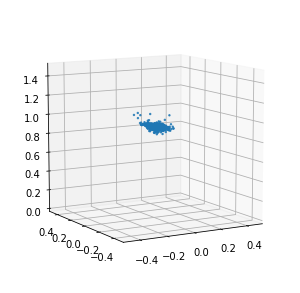

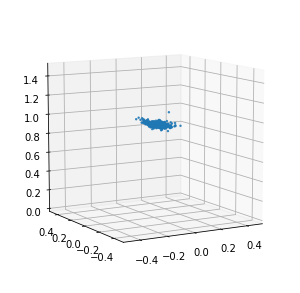

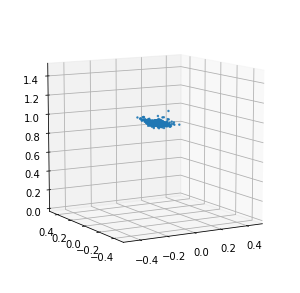

2301 (-0.1144408866763115, 0.012713819742202759)
2302 (-0.07502931505441665, -0.036720629781484604)
2303 (-0.08904436230659485, -0.037598978728055954)
2304 (-0.09117260426282883, -0.08170618116855621)
2305 (-0.10171376466751099, -0.09754932671785355)
2306 (-0.0925704449415207, -0.06335919350385666)
2307 (-0.08883359581232071, 0.006342854350805283)
2308 (-0.09149780124425888, -0.08933050185441971)
2309 (-0.09620250165462493, -0.08029134571552277)
2310 (-0.09618817567825318, -0.05077565088868141)
2311 (-0.0859058067202568, -0.053336113691329956)
2312 (-0.08941029161214828, 0.0032928907312452793)
2313 (-0.10074525773525238, 0.09297887980937958)
2314 (-0.10522111058235169, 0.000519843481015414)
2315 (-0.08581664115190506, -0.05073397979140282)
2316 (-0.08207776844501495, -0.015510451048612595)
2317 (-0.07383401840925216, -0.08986350893974304)
2318 (-0.10727231055498124, 0.04154733568429947)
2319 (-0.060885851085186, -0.10351593047380447)
2320 (-0.08999100029468536, -0.14535169303417206)
23

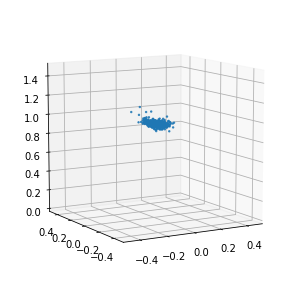

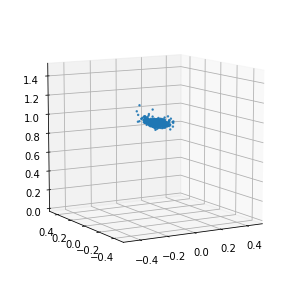

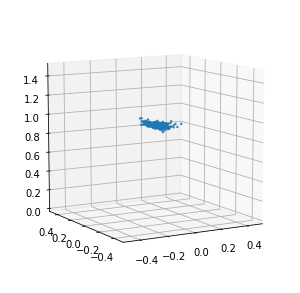

2351 (-0.07365803569555282, -0.08118053525686264)
2352 (-0.10050166249275208, -0.0648476630449295)
2353 (-0.09785003066062928, -0.13916847109794617)
2354 (-0.1020701065659523, -0.2135160118341446)
2355 (-0.10454630106687546, -0.17900925874710083)
2356 (-0.09075773358345032, -0.06480421125888824)
2357 (-0.10327519923448562, -0.07256726175546646)
2358 (-0.08885050863027573, -0.08309051394462585)
2359 (-0.11502089649438858, 0.15409661829471588)
2360 (-0.08656953275203705, 0.10032554715871811)
2361 (-0.07637934982776642, 0.04903532564640045)
2362 (-0.11700723618268967, 0.14248301088809967)
2363 (-0.07072349786758422, -0.030846869572997093)
2364 (-0.07526998817920685, -0.11199057847261429)
2365 (-0.08547346293926239, -0.11711978167295456)
2366 (-0.08963461071252823, -0.08113419264554977)
2367 (-0.08239275813102723, -0.017116885632276535)
2368 (-0.08554167002439499, 0.039406467229127884)
2369 (-0.0872186154127121, 0.06440307945013046)
2370 (-0.08477714955806732, -0.053647104650735855)
2371 (

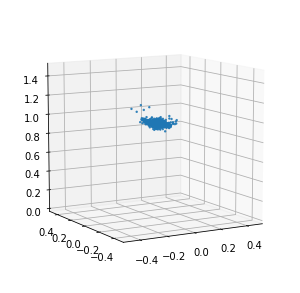

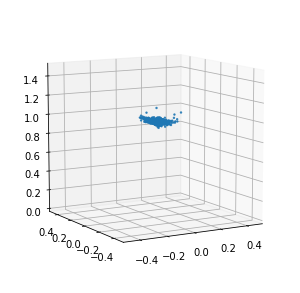

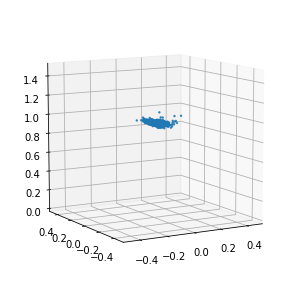

2401 (-0.07354127913713455, -0.02734820544719696)
2402 (-0.08271566331386566, 0.02791527286171913)
2403 (-0.07627511620521546, -0.02548074722290039)
2404 (-0.08468220829963684, -0.08000783622264862)
2405 (-0.0786096215248108, -0.0017411424778401852)
2406 (-0.07841358482837676, 0.022238226607441902)
2407 (-0.0846614420413971, 0.23710750043392181)
2408 (-0.07777327597141266, 0.22315752506256104)
2409 (-0.05455992221832275, 0.057986680418252945)
2410 (-0.089037124812603, 0.12207164615392685)
2411 (-0.08191086053848266, 0.023537494242191315)
2412 (-0.08059030026197433, 0.016612458974123)
2413 (-0.08395875990390778, 0.09879326820373535)
2414 (-0.0772712379693985, -0.0774395763874054)
2415 (-0.10892997086048126, -0.08358629047870636)
2416 (-0.06618224084377289, -0.06575928628444672)
2417 (-0.0716154471039772, -0.030584556981921196)
2418 (-0.07003490924835205, -0.005006383638828993)
2419 (-0.07514902353286743, 0.05383541062474251)
2420 (-0.08197667151689529, 0.08576707541942596)
2421 (-0.0859

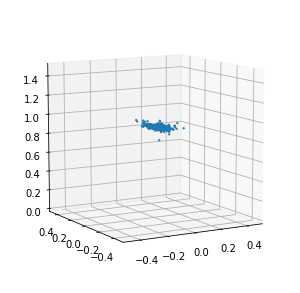

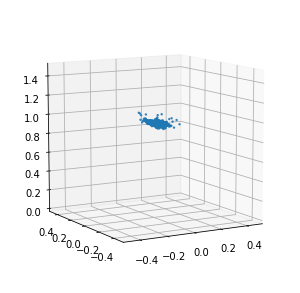

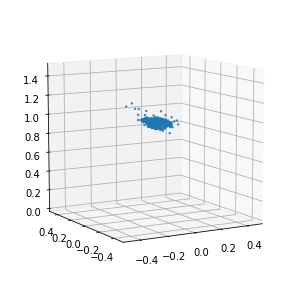

2451 (-0.05575844645500183, -0.06478623300790787)
2452 (-0.07602411657571792, 0.017180444672703743)
2453 (-0.1011500045657158, 0.09958754479885101)
2454 (-0.09939896613359452, 0.26116442680358887)
2455 (-0.053225232660770415, 0.1803472638130188)
2456 (-0.07637607008218765, 0.17871826887130737)
2457 (-0.09443406909704208, 0.2225075513124466)
2458 (-0.07384662926197053, 0.12587222456932068)
2459 (-0.07966260462999344, 0.13117705285549164)
2460 (-0.0734831303358078, 0.11992931365966797)
2461 (-0.0612525224685669, 0.11088468879461288)
2462 (-0.07090300172567368, 0.07414193451404572)
2463 (-0.08386911898851394, 0.06999222934246063)
2464 (-0.07384179979562759, 0.05041228234767914)
2465 (-0.07409727722406387, 0.0488521084189415)
2466 (-0.05360347032546997, 0.12413601577281952)
2467 (-0.07751690149307251, 0.09773704409599304)
2468 (-0.07614961713552475, 0.09427893906831741)
2469 (-0.08719171583652496, 0.09384077787399292)
2470 (-0.07177975922822952, 0.10445897281169891)
2471 (-0.07784433364868

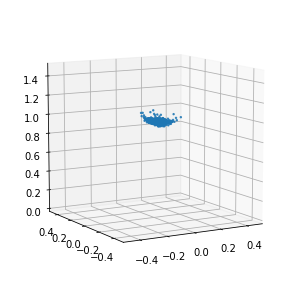

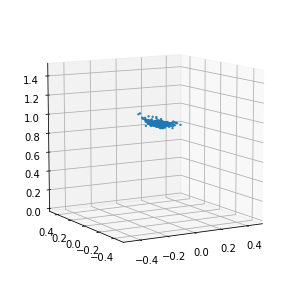

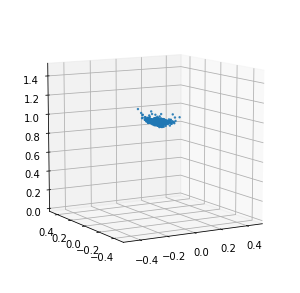

2501 (-0.09488623142242432, 0.21905924379825592)
2502 (-0.06485746502876281, 0.06641199439764023)
2503 (-0.08226049691438675, 0.10208188742399216)
2504 (-0.08347235769033431, 0.10379862040281296)
2505 (-0.08384263217449188, 0.092033252120018)
2506 (-0.08091562986373901, 0.1749068647623062)
2507 (-0.05113617181777954, 0.06862681359052658)
2508 (-0.0845105305314064, 0.08283460885286331)
2509 (-0.07117683291435242, 0.07563047111034393)
2510 (-0.08049536049365998, 0.19347307085990906)
2511 (-0.07037074565887451, 0.08274097740650177)
2512 (-0.08078168481588363, 0.0785210058093071)
2513 (-0.08846763670444488, 0.13722673058509827)
2514 (-0.05905764251947403, 0.07123924046754837)
2515 (-0.07283144891262054, 0.14212432503700256)
2516 (-0.0673733413219452, 0.06301369518041611)
2517 (-0.08171976506710052, 0.049446944147348404)
2518 (-0.08674777299165726, 0.10343081504106522)
2519 (-0.06701231002807617, 0.13498049974441528)
2520 (-0.07999185174703598, 0.05399518832564354)
2521 (-0.0908010438084602

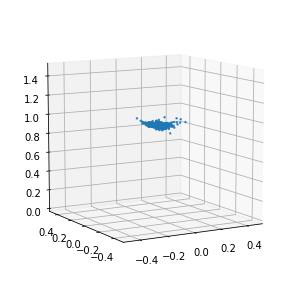

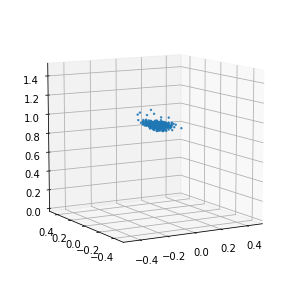

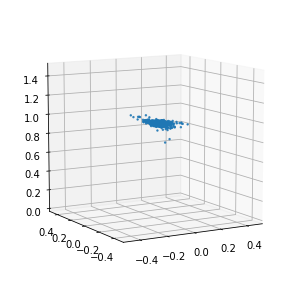

2551 (-0.08321263194084168, 0.08752931654453278)
2552 (-0.0830000326037407, 0.08038657903671265)
2553 (-0.07140279412269593, 0.05958525091409683)
2554 (-0.0675691619515419, 0.10021466016769409)
2555 (-0.07147814035415649, -0.004351913463324308)
2556 (-0.07039936184883118, 0.17624488472938538)
2557 (-0.060531321167945865, 0.19509457051753998)
2558 (-0.06570386439561844, 0.1736573725938797)
2559 (-0.06356100887060165, 0.19176700711250305)
2560 (-0.0671140804886818, 0.14189691841602325)
2561 (-0.08417847007513046, 0.1626041978597641)
2562 (-0.06021534651517868, 0.18477192521095276)
2563 (-0.09325800091028214, 0.17099235951900482)
2564 (-0.05626395642757416, 0.13799168169498444)
2565 (-0.08122335076332092, 0.1562366783618927)
2566 (-0.05963362753391266, 0.09487108141183853)
2567 (-0.05415691733360291, 0.0654381811618805)
2568 (-0.0764075443148613, 0.20581474900245667)
2569 (-0.05674485117197037, 0.11534805595874786)
2570 (-0.06001430451869964, 0.15165716409683228)
2571 (-0.0752389758825302

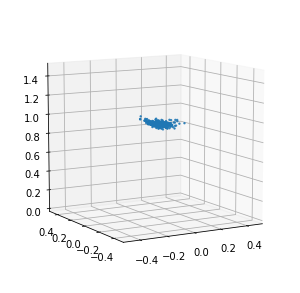

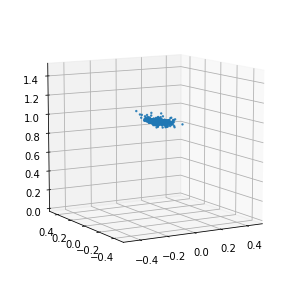

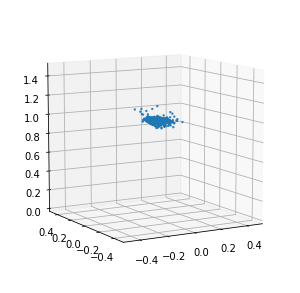

2601 (-0.0736328661441803, 0.23468269407749176)
2602 (-0.06511183977127075, 0.2183021754026413)
2603 (-0.07325383275747299, 0.24427203834056854)
2604 (-0.06486879885196686, 0.17029869556427002)
2605 (-0.06607317626476288, 0.15256597101688385)
2606 (-0.054851071536540986, 0.20979098975658417)
2607 (-0.08161899745464325, 0.13809825479984283)
2608 (-0.049217842519283295, 0.19982707500457764)
2609 (-0.0519130602478981, 0.14187534153461456)
2610 (-0.06102838665246964, 0.1517152190208435)
2611 (-0.05861513167619705, 0.16691738367080688)
2612 (-0.04802411943674088, 0.25678128004074097)
2613 (-0.05233219563961029, 0.1820077896118164)
2614 (-0.06956558227539063, 0.14371804893016815)
2615 (-0.06045429110527038, 0.22798004746437073)
2616 (-0.048950929939746854, 0.20383499562740326)
2617 (-0.0741590440273285, 0.12274309247732162)
2618 (-0.06096195429563522, 0.122952900826931)
2619 (-0.07071830555796624, 0.09740447998046875)
2620 (-0.06412901878356933, 0.16455355286598206)
2621 (-0.070444855093956,

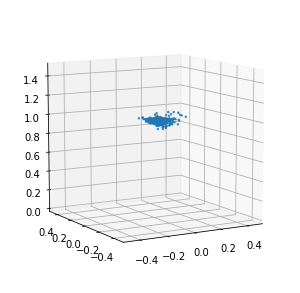

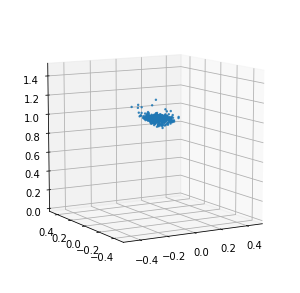

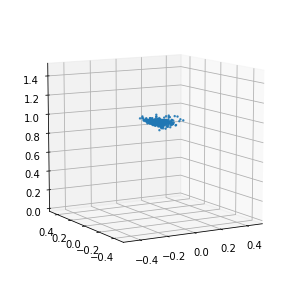

2651 (-0.06894934922456741, 0.2123996913433075)
2652 (-0.06112958043813706, 0.23997554183006287)
2653 (-0.06283491849899292, 0.28923365473747253)
2654 (-0.05570584833621979, 0.17891128361225128)
2655 (-0.05697120875120163, 0.17450156807899475)
2656 (-0.07457684725522995, 0.20207244157791138)
2657 (-0.05617890954017639, 0.16192428767681122)
2658 (-0.04945190250873566, 0.1472771018743515)
2659 (-0.06377379149198532, 0.1122157871723175)
2660 (-0.0575294554233551, 0.12699469923973083)
2661 (-0.05714386403560638, 0.16395717859268188)
2662 (-0.05291319936513901, 0.1393207311630249)
2663 (-0.06994141936302185, 0.1851274073123932)
2664 (-0.05244679450988769, 0.18388575315475464)
2665 (-0.0657672755420208, 0.21044154465198517)
2666 (-0.045286399126052854, 0.13161106407642365)
2667 (-0.050739902257919314, 0.11629453301429749)
2668 (-0.0603151872754097, 0.30180633068084717)
2669 (-0.06199306696653366, 0.30463749170303345)
2670 (-0.05888020247220993, 0.405417799949646)
2671 (-0.030859638750553132,

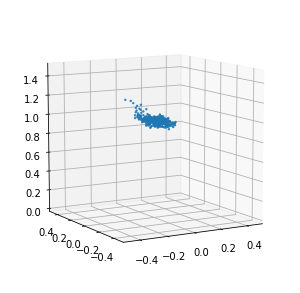

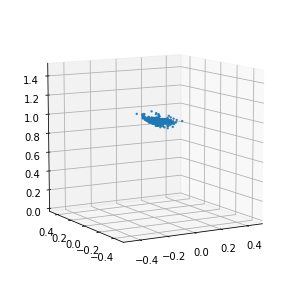

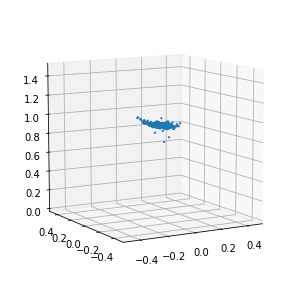

2701 (-0.045731940865516664, 0.23514991998672485)
2702 (-0.04843859672546387, 0.19983695447444916)
2703 (-0.06026671826839447, 0.2849893867969513)
2704 (-0.06670684665441513, 0.2549944221973419)
2705 (-0.06880538016557694, 0.2962205410003662)
2706 (-0.062474910914897916, 0.28457775712013245)
2707 (-0.05380388051271438, 0.23879016935825348)
2708 (-0.05998409166932106, 0.2219870239496231)
2709 (-0.06357486546039581, 0.18794074654579163)
2710 (-0.058156199753284454, 0.19040855765342712)
2711 (-0.05586828887462616, 0.20233017206192017)
2712 (-0.046905533969402315, 0.2104327380657196)
2713 (-0.05449696779251099, 0.21996913850307465)
2714 (-0.05624360293149948, 0.20209334790706635)
2715 (-0.06862652748823166, 0.3570127785205841)
2716 (-0.025349685549736024, 0.3193581700325012)
2717 (-0.0629581369459629, 0.23246322572231293)
2718 (-0.0600720465183258, 0.3472652733325958)
2719 (-0.06482264846563339, 0.28744080662727356)
2720 (-0.058549970388412476, 0.2344626486301422)
2721 (-0.0500540822744369

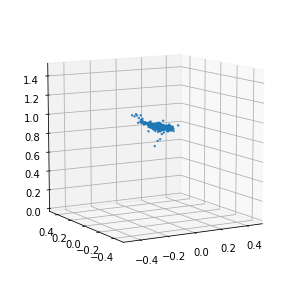

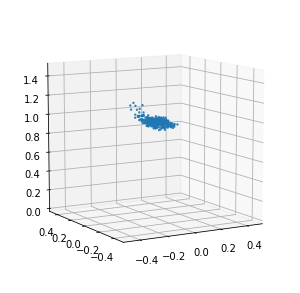

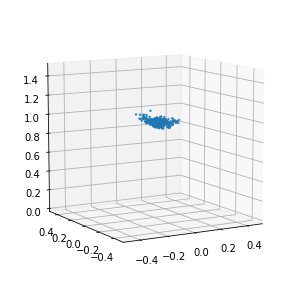

2751 (-0.05725675150752067, 0.3696404993534088)
2752 (-0.06477369666099549, 0.3370564579963684)
2753 (-0.05348792225122452, 0.37643831968307495)
2754 (-0.06511058360338211, 0.31286922097206116)
2755 (-0.0553009420633316, 0.2396308183670044)
2756 (-0.05965008810162544, 0.21904776990413666)
2757 (-0.07547441869974136, 0.2627201974391937)
2758 (-0.06125500500202179, 0.23191004991531372)
2759 (-0.05385533422231674, 0.13210025429725647)
2760 (-0.0669709488749504, 0.19478046894073486)
2761 (-0.08110172003507614, 0.20807547867298126)
2762 (-0.0479903444647789, 0.2760326862335205)
2763 (-0.05885560214519501, 0.31159669160842896)
2764 (-0.04703342169523239, 0.2832898199558258)
2765 (-0.07554134428501129, 0.35987868905067444)
2766 (-0.05573401153087616, 0.3149760067462921)
2767 (-0.057804505527019504, 0.30348706245422363)
2768 (-0.051157979667186736, 0.3040474057197571)
2769 (-0.07428631335496902, 0.29106244444847107)
2770 (-0.05826896578073502, 0.2865464389324188)
2771 (-0.04692118316888809, 0.

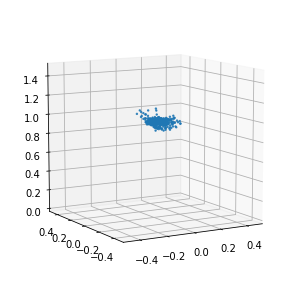

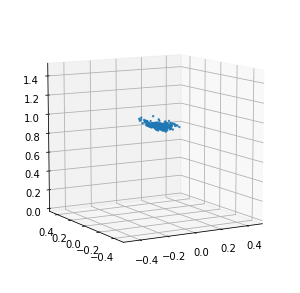

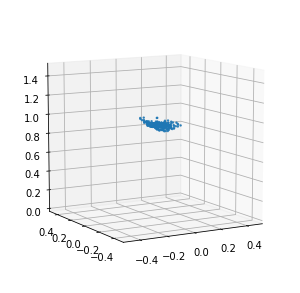

2801 (-0.08123795539140702, 0.38843998312950134)
2802 (-0.05449321120977402, 0.39243629574775696)
2803 (-0.04522295743227005, 0.38891711831092834)
2804 (-0.06586458906531334, 0.364256888628006)
2805 (-0.062480638921260837, 0.34567373991012573)
2806 (-0.03635376542806625, 0.34808671474456787)
2807 (-0.03017069399356842, 0.2765308916568756)
2808 (-0.04840228334069252, 0.3043491244316101)
2809 (-0.054317301511764525, 0.29957735538482666)
2810 (-0.054409758746623994, 0.2860496938228607)
2811 (-0.06793457865715027, 0.2972002923488617)
2812 (-0.06636841446161271, 0.31569838523864746)
2813 (-0.05806244760751724, 0.3023425042629242)
2814 (-0.06166635155677795, 0.25816822052001953)
2815 (-0.04500701576471329, 0.28132349252700806)
2816 (-0.04970162510871887, 0.2893010973930359)
2817 (-0.05374763906002045, 0.2837286591529846)
2818 (-0.04878408312797546, 0.36887437105178833)
2819 (-0.04521549493074417, 0.3922180235385895)
2820 (-0.0621033787727356, 0.40370216965675354)
2821 (-0.04269065111875534, 

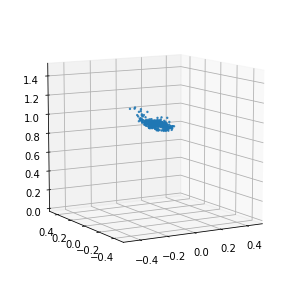

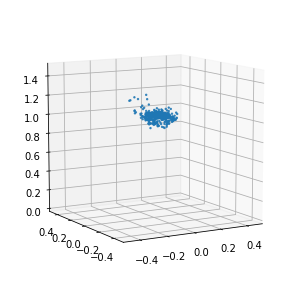

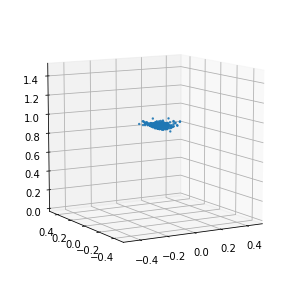

2851 (-0.05143866837024689, 0.3570481538772583)
2852 (-0.07051246762275695, 0.3863978981971741)
2853 (-0.04617287367582321, 0.30179518461227417)
2854 (-0.06493067145347595, 0.3455977737903595)
2855 (-0.03978790640830994, 0.38126319646835327)
2856 (-0.031904231011867526, 0.41798916459083557)
2857 (-0.04717789888381958, 0.45522400736808777)
2858 (-0.0452786386013031, 0.4035298824310303)
2859 (-0.04873494803905487, 0.4115344285964966)
2860 (-0.026533481478691102, 0.35929855704307556)
2861 (-0.033576592803001404, 0.4903249442577362)
2862 (-0.04118097424507141, 0.4672471582889557)
2863 (-0.0440731942653656, 0.41035616397857666)
2864 (-0.03438073396682739, 0.3871420919895172)
2865 (-0.03512090146541595, 0.41244766116142273)
2866 (-0.03684811592102051, 0.4483124613761902)
2867 (-0.05166017860174179, 0.3937574028968811)
2868 (-0.03941911831498146, 0.33081749081611633)
2869 (-0.0688722163438797, 0.4200378358364105)
2870 (-0.04104061424732208, 0.32838907837867737)
2871 (-0.05942888557910919, 0.3

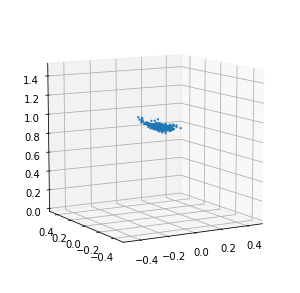

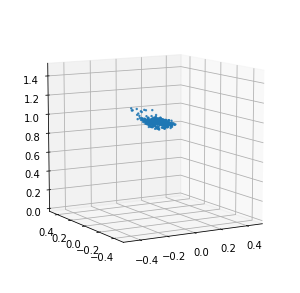

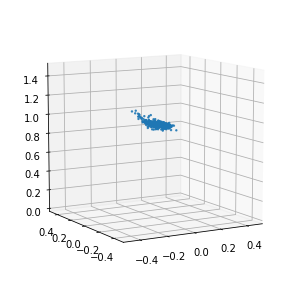

2901 (-0.03693416714668274, 0.3819935619831085)
2902 (-0.03156380802392959, 0.35853707790374756)
2903 (-0.01957627907395363, 0.39100944995880127)
2904 (-0.048428983241319654, 0.4388645589351654)
2905 (-0.035399149358272555, 0.4223925769329071)
2906 (-0.04308823347091675, 0.35730743408203125)
2907 (-0.032210995256900785, 0.3455049991607666)
2908 (-0.03855092972517014, 0.34831029176712036)
2909 (-0.051386433839797976, 0.31453749537467957)
2910 (-0.03885177373886108, 0.32023024559020996)
2911 (-0.02362992912530899, 0.3098415434360504)
2912 (-0.03156022280454636, 0.3501817286014557)
2913 (-0.05463121831417084, 0.4351402521133423)
2914 (-0.04427309632301331, 0.43330514430999756)
2915 (-0.032528828084468844, 0.43728718161582947)
2916 (-0.05310555398464203, 0.3485674262046814)
2917 (-0.022285334765911102, 0.37375080585479736)
2918 (-0.06337548866868019, 0.3382352888584137)
2919 (-0.04260866641998291, 0.36047661304473877)
2920 (-0.0445064440369606, 0.4867006540298462)
2921 (-0.0658743411302566

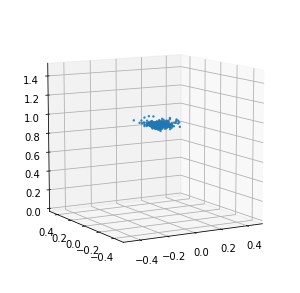

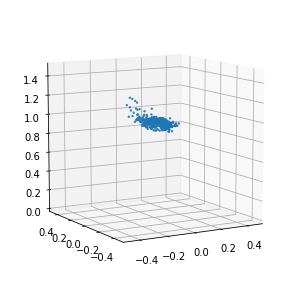

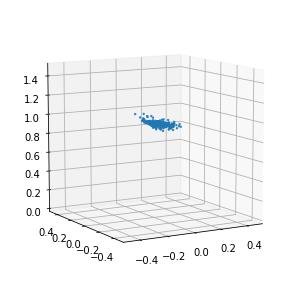

2951 (-0.075372014939785, 0.35433056950569153)
2952 (-0.0693476676940918, 0.3322305381298065)
2953 (-0.04170370250940323, 0.38036835193634033)
2954 (-0.055372771620750424, 0.362949401140213)
2955 (-0.03399845361709595, 0.3301798105239868)
2956 (-0.040523388981819154, 0.32134655117988586)
2957 (-0.055291055142879485, 0.2999981641769409)
2958 (-0.04989919513463974, 0.277512788772583)
2959 (-0.026511718332767487, 0.2968722879886627)
2960 (-0.0415566086769104, 0.20434290170669556)
2961 (-0.041883887350559236, 0.19555526971817017)
2962 (-0.03434632271528244, 0.22137333452701569)
2963 (-0.03649862855672836, 0.2203637659549713)
2964 (-0.038842760026454926, 0.146847203373909)
2965 (-0.030645255744457246, 0.20605497062206268)
2966 (-0.04321077689528465, 0.34088438749313354)
2967 (-0.0275077223777771, 0.36200034618377686)
2968 (-0.034308919310569765, 0.31481072306632996)
2969 (-0.037261389940977094, 0.297717809677124)
2970 (-0.0524946928024292, 0.37291502952575684)
2971 (-0.0419819712638855, 0.3

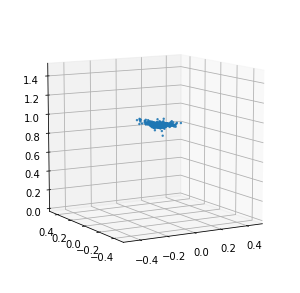

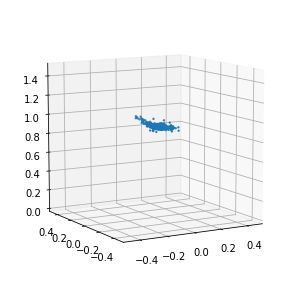

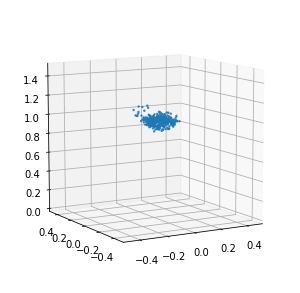

3001 (-0.05287368893623352, 0.29234495759010315)
3002 (-0.07732885107398033, 0.46494606137275696)
3003 (-0.0334310345351696, 0.37694332003593445)
3004 (-0.06771625429391862, 0.30392467975616455)
3005 (-0.034855905920267105, 0.2041187733411789)
3006 (-0.030475278943777086, 0.2549896538257599)
3007 (-0.04523409754037857, 0.2189399152994156)
3008 (-0.04470785558223724, 0.2338591367006302)
3009 (-0.03457920402288437, 0.3246389329433441)
3010 (-0.023517562448978423, 0.3956611752510071)
3011 (-0.03650037571787834, 0.3581441640853882)
3012 (-0.05391017645597458, 0.35452941060066223)
3013 (-0.04006315097212791, 0.4476863145828247)
3014 (-0.028984227776527406, 0.3225689232349396)
3015 (-0.04828231483697891, 0.2883039712905884)
3016 (-0.010200789570808411, 0.30301645398139954)
3017 (-0.03584789261221886, 0.2738751173019409)
3018 (-0.01644408851861954, 0.3138103783130646)
3019 (-0.03145559728145599, 0.35672104358673096)
3020 (-0.027730219811201096, 0.3406667411327362)
3021 (-0.028906701505184172,

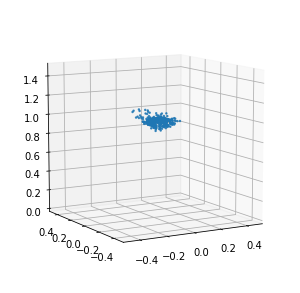

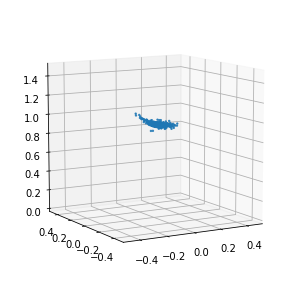

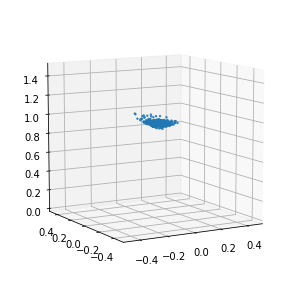

3051 (-0.06315942704677582, 0.31353649497032166)
3052 (-0.029700933396816252, 0.3071838319301605)
3053 (-0.021776816248893736, 0.3168410360813141)
3054 (-0.03570806458592415, 0.3149491846561432)
3055 (-0.03168280720710755, 0.2654227912425995)
3056 (-0.05764016956090927, 0.24181148409843445)
3057 (-0.02628713995218277, 0.42979541420936584)
3058 (-0.03317058011889458, 0.3072839677333832)
3059 (-0.048092736303806304, 0.19578251242637634)
3060 (-0.07430486232042313, 0.3167254328727722)
3061 (-0.042467035353183746, 0.35525885224342346)
3062 (-0.04376696199178696, 0.28462812304496765)
3063 (-0.041115307807922365, 0.37047043442726135)
3064 (-0.03363905549049377, 0.39807671308517456)
3065 (-0.031828483939170836, 0.43079787492752075)
3066 (-0.04343256503343582, 0.3381965756416321)
3067 (-0.04478927329182625, 0.4415922462940216)
3068 (-0.026471726596355438, 0.37279021739959717)
3069 (-0.03150413259863853, 0.36749881505966187)
3070 (-0.04592456519603729, 0.42102569341659546)
3071 (-0.041256825625

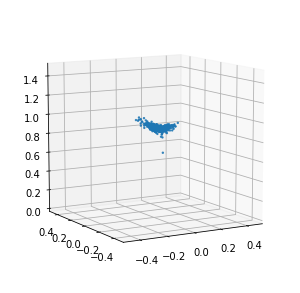

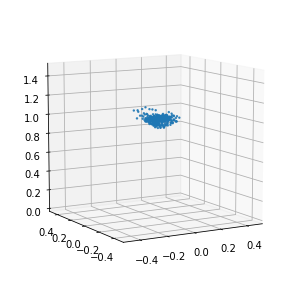

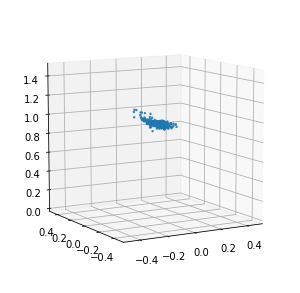

3101 (-0.06558861285448074, 0.32876887917518616)
3102 (-0.029159626364707945, 0.3620676100254059)
3103 (-0.0228801429271698, 0.23671558499336243)
3104 (-0.03022378608584404, 0.21849259734153748)
3105 (-0.031951024383306506, 0.22124724090099335)
3106 (-0.04341408386826515, 0.2037666290998459)
3107 (-0.03179125040769577, 0.30088886618614197)
3108 (-0.027880312502384187, 0.20099596679210663)
3109 (-0.02408394366502762, 0.16460485756397247)
3110 (-0.04854565262794495, 0.18800406157970428)
3111 (-0.026622144132852556, 0.16234344244003296)
3112 (-0.025985872745513915, 0.2897460460662842)
3113 (-0.032748644053936, 0.23738843202590942)
3114 (-0.01635989546775818, 0.3718535602092743)
3115 (-0.022005750238895415, 0.25429093837738037)
3116 (-0.0476392462849617, 0.3030022084712982)
3117 (-0.03631405159831047, 0.20798330008983612)
3118 (-0.06020217910408974, 0.27365559339523315)
3119 (-0.020004716515541077, 0.3467887043952942)
3120 (-0.01500960737466812, 0.3529202342033386)
3121 (-0.007888115942478

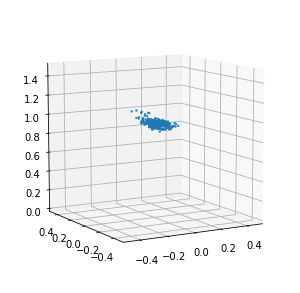

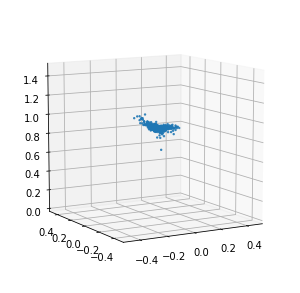

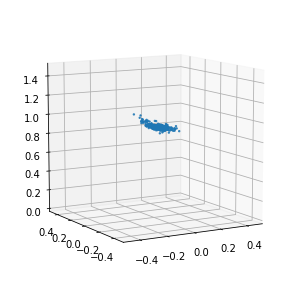

3151 (-0.03409012109041214, 0.1609702706336975)
3152 (-0.03187369853258133, 0.2157943695783615)
3153 (-0.03101418912410736, 0.23217716813087463)
3154 (-0.03067822754383087, 0.35515883564949036)
3155 (-0.02519645243883133, 0.256196528673172)
3156 (-0.018387451767921448, 0.26125019788742065)
3157 (-0.026148441433906554, 0.2602558732032776)
3158 (-0.032698482275009155, 0.2992648184299469)
3159 (-0.026183950155973433, 0.2313222885131836)
3160 (-0.018405383080244066, 0.25620609521865845)
3161 (-0.04201661199331284, 0.2190810739994049)
3162 (-0.02512597218155861, 0.21304357051849365)
3163 (-0.0292022243142128, 0.22666646540164948)
3164 (-0.015028203278779984, 0.5303661823272705)
3165 (-0.004676449298858643, 0.3142467439174652)
3166 (-0.022108164429664613, 0.27408742904663086)
3167 (-0.022784288972616196, 0.23460198938846588)
3168 (-0.03584075272083283, 0.3103777766227722)
3169 (-0.036938874423503874, 0.2882463335990906)
3170 (-0.023606954514980315, 0.20364177227020264)
3171 (-0.0255822926759

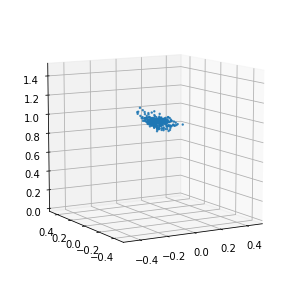

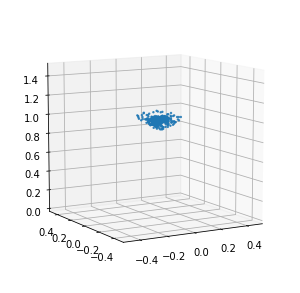

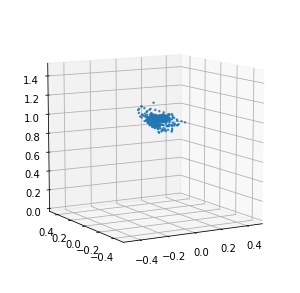

3201 (-0.038100007176399234, 0.3101116120815277)
3202 (-0.05292261764407158, 0.26562735438346863)
3203 (-0.02639329731464386, 0.25568675994873047)
3204 (-0.032313643395900725, 0.2911384701728821)
3205 (-0.024189407378435133, 0.2123471051454544)
3206 (-0.024770110100507736, 0.17699651420116425)
3207 (-0.02862771973013878, 0.23896092176437378)
3208 (-0.0193215012550354, 0.26219138503074646)
3209 (-0.04186937138438225, 0.28604698181152344)
3210 (-0.020801046490669252, 0.2791450619697571)
3211 (-0.027143752574920653, 0.2653883099555969)
3212 (-0.021787093579769136, 0.29520073533058167)
3213 (-0.026233871281147004, 0.2705867290496826)
3214 (-0.02262660190463066, 0.2947218120098114)
3215 (-0.019920813292264937, 0.2914240062236786)
3216 (-0.02082437351346016, 0.2559567391872406)
3217 (-0.015427904576063156, 0.18536272644996643)
3218 (-0.023732618242502213, 0.1540054827928543)
3219 (-0.025903227925300597, 0.27804017066955566)
3220 (-0.027437303215265274, 0.19766923785209656)
3221 (-0.011531862

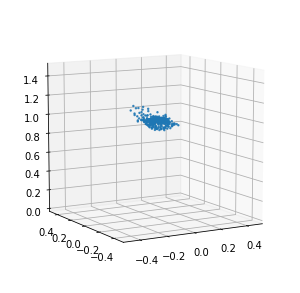

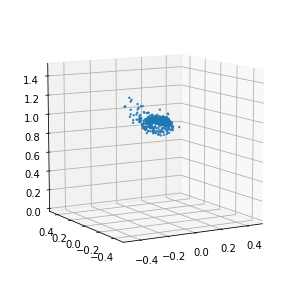

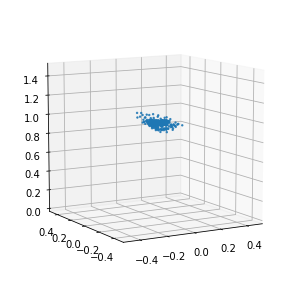

3251 (-0.016495655477046966, 0.24920742213726044)
3252 (-0.024715366959571838, 0.209157794713974)
3253 (-0.02992878183722496, 0.17095300555229187)
3254 (-0.027311588823795318, 0.34732094407081604)
3255 (-0.031143100559711458, 0.2823661267757416)
3256 (-0.02373867779970169, 0.20336180925369263)
3257 (-0.03679588958621025, 0.22038042545318604)
3258 (-0.028261848539114, 0.20015354454517365)
3259 (-0.014017286151647568, 0.17751342058181763)
3260 (-0.03680286034941673, 0.14252854883670807)
3261 (-0.0126820370554924, 0.21172435581684113)
3262 (-0.027472123503684998, 0.21895797550678253)
3263 (-0.04132569283246994, 0.341035395860672)
3264 (-0.025658410042524338, 0.3289302587509155)
3265 (-0.02247714102268219, 0.25675541162490845)
3266 (-0.024395698308944704, 0.19666050374507904)
3267 (-0.02794245257973671, 0.2685256600379944)
3268 (-0.017626599967479707, 0.19852091372013092)
3269 (-0.019491591304540635, 0.26343032717704773)
3270 (-0.021761387586593628, 0.12459162622690201)
3271 (-0.0249152027

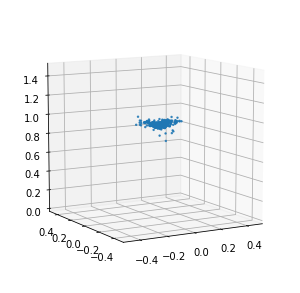

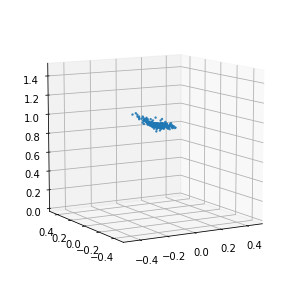

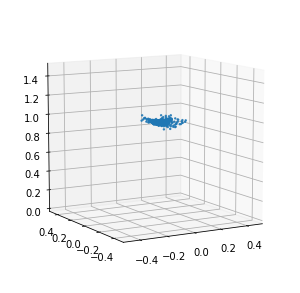

3301 (-0.03775136172771454, 0.20163188874721527)
3302 (-0.03273749724030495, 0.18480537831783295)
3303 (-0.032814090698957445, 0.30168038606643677)
3304 (-0.027937161922454833, 0.2358301877975464)
3305 (-0.03267846256494522, 0.2128317803144455)
3306 (-0.02167908549308777, 0.16776734590530396)
3307 (-0.0358136922121048, 0.20101220905780792)
3308 (-0.004529257118701935, 0.1532600075006485)
3309 (-0.02015722319483757, 0.15160755813121796)
3310 (-0.02990487068891525, 0.2727450132369995)
3311 (-0.026344746351242065, 0.21727032959461212)
3312 (-0.016206096112728118, 0.25570207834243774)
3313 (-0.02865075245499611, 0.21031005680561066)
3314 (-0.032200653851032254, 0.25770509243011475)
3315 (-0.03095165491104126, 0.2130170464515686)
3316 (-0.04413837417960167, 0.2142462581396103)
3317 (-0.027355773746967314, 0.19794343411922455)
3318 (-0.012352488934993744, 0.16150537133216858)
3319 (-0.037251869589090346, 0.3003200888633728)
3320 (-0.021048291027545928, 0.317124605178833)
3321 (-0.01499123796

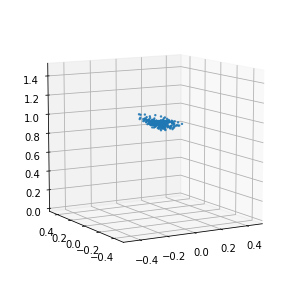

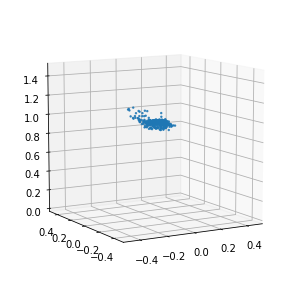

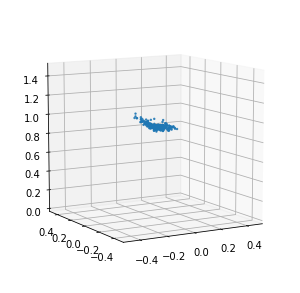

3351 (-0.02720932140946388, 0.290618360042572)
3352 (-0.0338361106812954, 0.2198428362607956)
3353 (-0.04609556570649147, 0.26081934571266174)
3354 (-0.025835975259542465, 0.2601417899131775)
3355 (-0.032821132242679595, 0.23850783705711365)
3356 (-0.03694838434457779, 0.24384327232837677)
3357 (-0.027372337877750397, 0.36036622524261475)
3358 (-0.030860547721385957, 0.2816227972507477)
3359 (-0.03221613317728043, 0.2722553610801697)
3360 (-0.028806692361831664, 0.24591971933841705)
3361 (-0.03230875805020332, 0.2132236659526825)
3362 (-0.05577244311571121, 0.4091429114341736)
3363 (-0.02330825328826904, 0.22446304559707642)
3364 (-0.029759249091148375, 0.27985164523124695)
3365 (-0.03945763111114502, 0.36437076330184937)
3366 (-0.01098906174302101, 0.3183703124523163)
3367 (-0.032562863826751706, 0.21190997958183289)
3368 (-0.040192128717899324, 0.2624036371707916)
3369 (-0.021770913153886795, 0.20036034286022186)
3370 (-0.040458622574806216, 0.33836570382118225)
3371 (-0.014141348004

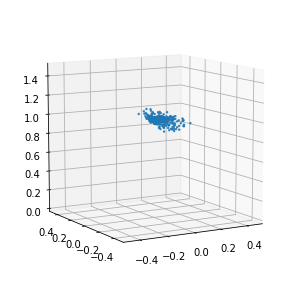

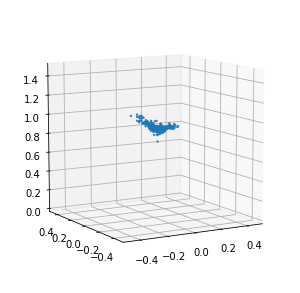

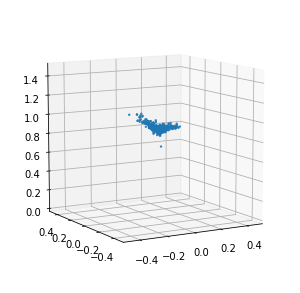

3401 (-0.03518894165754318, 0.23828831315040588)
3402 (-0.03398948609828949, 0.327260285615921)
3403 (-0.02106416001915932, 0.3628406226634979)
3404 (-0.04724333137273788, 0.345478892326355)
3405 (-0.02528698444366455, 0.23882660269737244)
3406 (-0.06388086080551147, 0.23516063392162323)
3407 (-0.04294292107224464, 0.22682559490203857)
3408 (-0.03280866369605064, 0.21721729636192322)
3409 (-0.03489173427224159, 0.19721989333629608)
3410 (-0.040055117756128314, 0.2884173095226288)
3411 (-0.001236499845981598, 0.32119864225387573)
3412 (-0.049534092843532565, 0.30722081661224365)
3413 (-0.03877100497484207, 0.3093723952770233)
3414 (-0.03780620917677879, 0.31161582469940186)
3415 (-0.04053776264190674, 0.22975903749465942)
3416 (-0.03793796598911285, 0.32119259238243103)
3417 (-0.04517257809638977, 0.3346976339817047)
3418 (-0.02488424926996231, 0.20179229974746704)
3419 (-0.045092006027698514, 0.28309714794158936)
3420 (-0.02233503609895706, 0.2574223577976227)
3421 (-0.0286359444260597

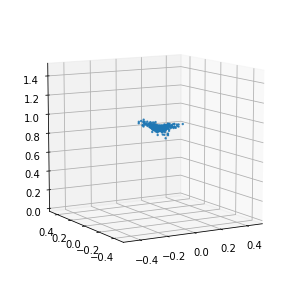

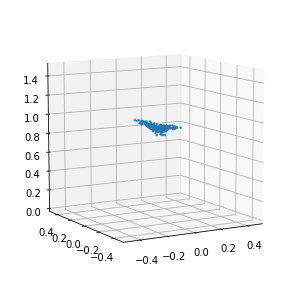

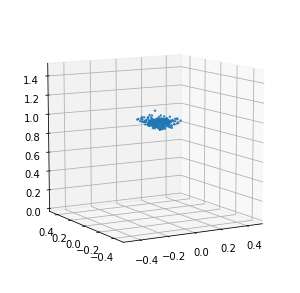

3451 (-0.02914166897535324, 0.3465639352798462)
3452 (-0.035659226775169375, 0.2500132620334625)
3453 (-0.03488746210932732, 0.2717563211917877)
3454 (-0.037607185542583466, 0.3315787613391876)
3455 (-0.03427239954471588, 0.3795977830886841)
3456 (-0.020514100044965743, 0.33822181820869446)
3457 (-0.049864863604307176, 0.3569011688232422)
3458 (-0.03995614051818848, 0.4682554006576538)
3459 (-0.030419917404651643, 0.4496617615222931)
3460 (-0.019891802966594697, 0.3753069043159485)
3461 (-0.05100454539060593, 0.3320583999156952)
3462 (-0.03229418620467186, 0.279135137796402)
3463 (-0.05356396362185478, 0.30943116545677185)
3464 (-0.04097205922007561, 0.2664150297641754)
3465 (-0.03731472715735436, 0.3184545934200287)
3466 (-0.04970014542341232, 0.3425678312778473)
3467 (-0.012212029099464417, 0.32263314723968506)
3468 (-0.024093763530254365, 0.3956739008426666)
3469 (-0.04118712246417999, 0.3402232825756073)
3470 (-0.06158237606287002, 0.49031248688697815)
3471 (-0.03585042059421539, 0

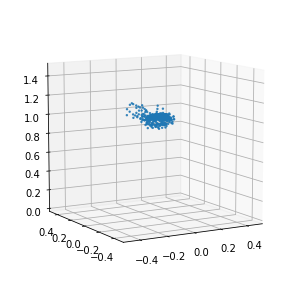

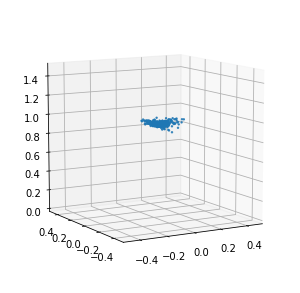

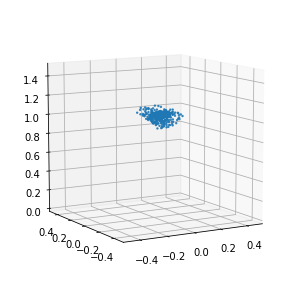

3501 (-0.03415733426809311, 0.2779887318611145)
3502 (-0.015437312424182892, 0.24110405147075653)
3503 (-0.03224077299237251, 0.16842670738697052)
3504 (-0.03560434877872467, 0.1724132001399994)
3505 (-0.03600869476795197, 0.33063751459121704)
3506 (-0.018065015226602553, 0.2661489248275757)
3507 (-0.038840093463659284, 0.2703912854194641)
3508 (-0.03859889730811119, 0.32218214869499207)
3509 (-0.03240079656243324, 0.2039741575717926)
3510 (-0.039739517867565154, 0.2061777561903)
3511 (-0.03070956841111183, 0.16291695833206177)
3512 (-0.03612065464258194, 0.24109479784965515)
3513 (-0.05505000129342079, 0.3289056420326233)
3514 (-0.036279264092445376, 0.35107219219207764)
3515 (-0.015466791391372681, 0.27192413806915283)
3516 (-0.03793032690882683, 0.2650420665740967)
3517 (-0.03601437360048294, 0.3648843467235565)
3518 (-0.03244302198290825, 0.2854137420654297)
3519 (-0.021782253682613373, 0.24987953901290894)
3520 (-0.034492258727550504, 0.3032113313674927)
3521 (-0.02400736063718795

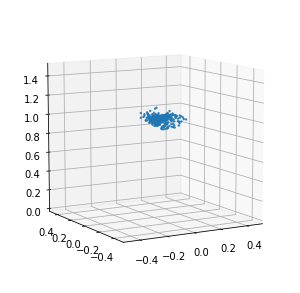

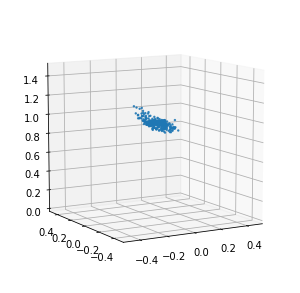

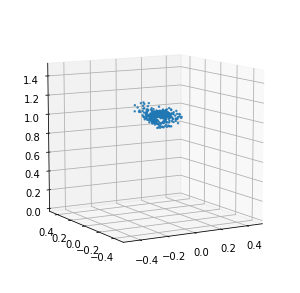

3551 (-0.03664191365242005, 0.34410080313682556)
3552 (-0.028617263585329056, 0.2641493082046509)
3553 (-0.023799648880958556, 0.16739551723003387)
3554 (-0.039065885543823245, 0.22100895643234253)
3555 (-0.025082934647798538, 0.18255075812339783)
3556 (-0.03262571468949318, 0.23677587509155273)
3557 (-0.02799922376871109, 0.3398185670375824)
3558 (-0.027107250690460206, 0.3579457104206085)
3559 (-0.006073647737503051, 0.23128929734230042)
3560 (-0.023508723825216293, 0.24175697565078735)
3561 (-0.046039500087499616, 0.21537017822265625)
3562 (-0.0256598636507988, 0.2834286391735077)
3563 (-0.02124612107872963, 0.2412797212600708)
3564 (-0.027645260095596313, 0.22452986240386963)
3565 (-0.04215912073850632, 0.3993785083293915)
3566 (-0.030663163959980012, 0.33454638719558716)
3567 (-0.02157619148492813, 0.2285875529050827)
3568 (-0.018884003162384033, 0.21892794966697693)
3569 (-0.0362571194767952, 0.23416082561016083)
3570 (-0.015210364758968354, 0.2120656967163086)
3571 (-0.026453688

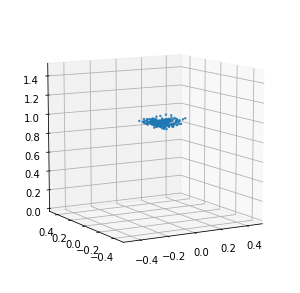

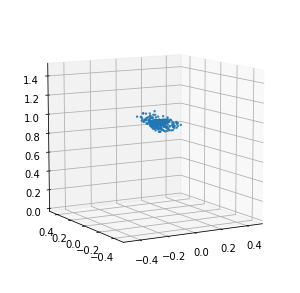

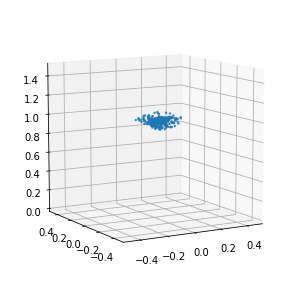

3601 (-0.052527057379484175, 0.2253439873456955)
3602 (-0.0189568430185318, 0.2849937081336975)
3603 (-0.02017742469906807, 0.24166563153266907)
3604 (-0.025376950204372407, 0.27928775548934937)
3605 (-0.013583993911743164, 0.2486102283000946)
3606 (-0.06606530696153641, 0.34788253903388977)
3607 (-0.010226225852966309, 0.35599181056022644)
3608 (-0.01656472310423851, 0.23584510385990143)
3609 (-0.03312546759843826, 0.2511834502220154)
3610 (-0.03288060799241066, 0.37897440791130066)
3611 (-0.02499883696436882, 0.3171982765197754)
3612 (-0.026955195516347886, 0.26879623532295227)
3613 (-0.01892252266407013, 0.21293626725673676)
3614 (-0.032725345343351364, 0.3230312466621399)
3615 (-0.025680860877037047, 0.24881912767887115)
3616 (-0.033386855572462085, 0.25425443053245544)
3617 (-0.0265415258705616, 0.23562771081924438)
3618 (-0.03172493204474449, 0.2845848500728607)
3619 (-0.04174477681517601, 0.3064475357532501)
3620 (-0.018637193739414214, 0.35972678661346436)
3621 (-0.023747571557

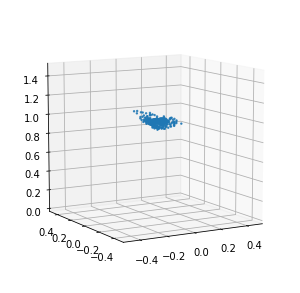

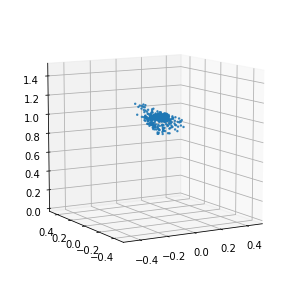

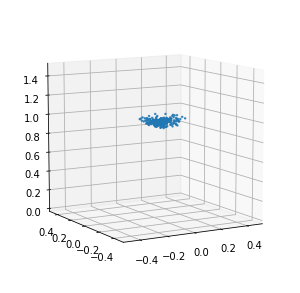

3651 (-0.05179655402898788, 0.30688658356666565)
3652 (-0.047296229749917984, 0.4843893349170685)
3653 (-0.033671528846025464, 0.3152673542499542)
3654 (-0.034060731530189514, 0.29963934421539307)
3655 (-0.031183458864688873, 0.2546197474002838)
3656 (-0.03362762480974198, 0.308212012052536)
3657 (-0.031874070316553114, 0.258301705121994)
3658 (-0.041988687962293623, 0.3024784326553345)
3659 (-0.008817516267299652, 0.33868125081062317)
3660 (-0.023947326838970183, 0.3515506684780121)
3661 (-0.03352114856243134, 0.3583715856075287)
3662 (-0.033674702793359754, 0.39716827869415283)
3663 (-0.03491185531020165, 0.32070863246917725)
3664 (-0.051340454071760175, 0.2950194478034973)
3665 (-0.041558316349983214, 0.3934963345527649)
3666 (-0.02516317889094353, 0.327987939119339)
3667 (-0.035418829321861266, 0.2926954925060272)
3668 (-0.02663935348391533, 0.32171812653541565)
3669 (-0.03938726782798767, 0.24856574833393097)
3670 (-0.04114683344960213, 0.32111287117004395)
3671 (-0.03184431046247

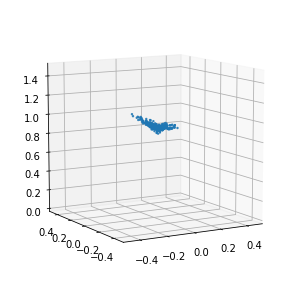

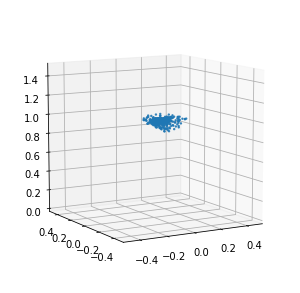

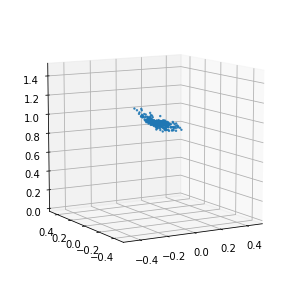

3701 (-0.02228142097592354, 0.28678929805755615)
3702 (-0.03406560570001602, 0.3048988878726959)
3703 (-0.029650859534740448, 0.33935436606407166)
3704 (-0.019722751528024673, 0.4246515929698944)
3705 (-0.03344104290008545, 0.365129292011261)
3706 (-0.020158734172582626, 0.34001925587654114)
3707 (-0.030169712007045747, 0.38494980335235596)
3708 (-0.006419777125120163, 0.31697192788124084)
3709 (-0.027906597405672074, 0.3293900191783905)
3710 (-0.025127815455198287, 0.2718305289745331)
3711 (-0.031377924233675004, 0.23610591888427734)
3712 (-0.035096187889575955, 0.25614655017852783)
3713 (-0.025706613063812257, 0.23443908989429474)
3714 (-0.02090786024928093, 0.2624113857746124)
3715 (-0.03007534667849541, 0.3051488995552063)
3716 (-0.03393711373209953, 0.3145240247249603)
3717 (-0.037271798402070996, 0.22956985235214233)
3718 (-0.023580501973628997, 0.21975719928741455)
3719 (-0.027577558904886244, 0.21969276666641235)
3720 (-0.029482928663492204, 0.26084861159324646)
3721 (-0.028615

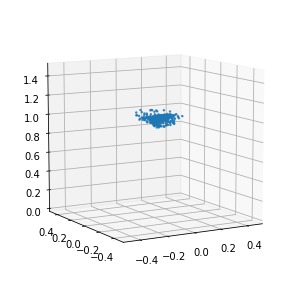

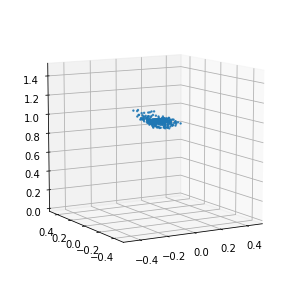

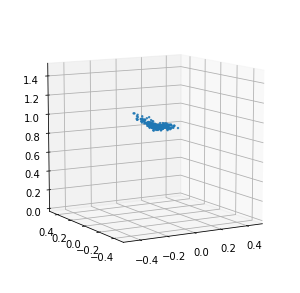

3751 (-0.036800742894411084, 0.33164188265800476)
3752 (-0.03033185675740242, 0.36953943967819214)
3753 (-0.03864381089806557, 0.2578447461128235)
3754 (-0.06658271551132203, 0.3418234884738922)
3755 (-0.02859930619597435, 0.24449506402015686)
3756 (-0.029999890178442002, 0.2469136267900467)
3757 (-0.032208846509456636, 0.31026148796081543)
3758 (-0.0392208531498909, 0.3905184268951416)
3759 (-0.022670016437768937, 0.37480589747428894)
3760 (-0.032995307445526124, 0.350075364112854)
3761 (-0.03004445806145668, 0.33190178871154785)
3762 (-0.02343027964234352, 0.26969483494758606)
3763 (-0.04303241372108459, 0.26512396335601807)
3764 (-0.05221390053629875, 0.24538585543632507)
3765 (-0.02570313513278961, 0.23102670907974243)
3766 (-0.024117546528577803, 0.23293153941631317)
3767 (-0.0410014733672142, 0.19092078506946564)
3768 (-0.03418071791529655, 0.2796671390533447)
3769 (-0.02830478847026825, 0.3943618834018707)
3770 (-0.020557606220245363, 0.2717497944831848)
3771 (-0.036328590661287

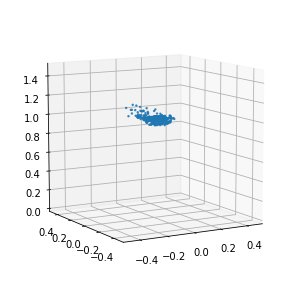

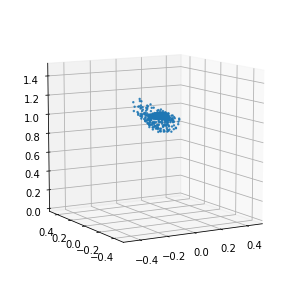

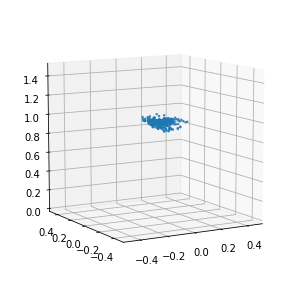

3801 (-0.01664361506700516, 0.1645938903093338)
3802 (-0.0309215173125267, 0.19184771180152893)
3803 (-0.02330455482006073, 0.2817099094390869)
3804 (-0.01693015396595001, 0.3046727180480957)
3805 (-0.03915262594819069, 0.22998623549938202)
3806 (-0.031048583984375, 0.21105563640594482)
3807 (-0.05175917223095894, 0.27777159214019775)
3808 (-0.03451112061738968, 0.21736149489879608)
3809 (-0.027478118240833283, 0.2405615597963333)
3810 (-0.024084755778312684, 0.2867331802845001)
3811 (-0.026371268182992937, 0.23541130125522614)
3812 (-0.029549507051706315, 0.22194570302963257)
3813 (-0.02771456092596054, 0.23162662982940674)
3814 (-0.024065857380628587, 0.22466011345386505)
3815 (-0.019095100462436676, 0.25560954213142395)
3816 (-0.016082404553890227, 0.22291359305381775)
3817 (-0.030555037409067155, 0.22975002229213715)
3818 (-0.039814415574073794, 0.26966461539268494)
3819 (-0.040644490718841554, 0.35309600830078125)
3820 (-0.023062223196029664, 0.37135326862335205)
3821 (-0.02104830

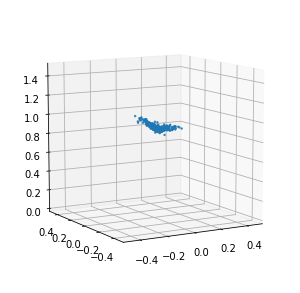

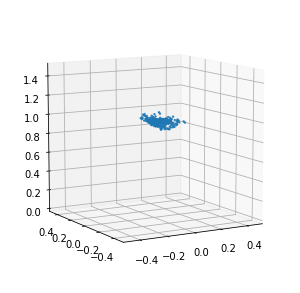

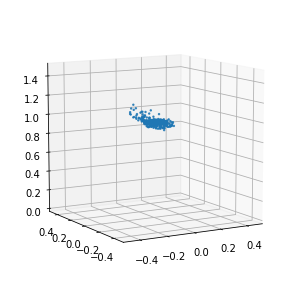

3851 (-0.008668183535337447, 0.2847883999347687)
3852 (-0.03228494077920914, 0.22591720521450043)
3853 (-0.024740047752857208, 0.2386166751384735)
3854 (-0.041471919417381285, 0.25802478194236755)
3855 (-0.019838671386241912, 0.24040792882442474)
3856 (-0.03433602824807167, 0.3065449595451355)
3857 (-0.01573122590780258, 0.3914302587509155)
3858 (-0.0215312160551548, 0.33511123061180115)
3859 (-0.04655812531709671, 0.3518548607826233)
3860 (-0.00830392837524414, 0.29751646518707275)
3861 (-0.028181294351816176, 0.24509435892105103)
3862 (-0.03911658897995949, 0.27210721373558044)
3863 (-0.036920880526304246, 0.27065789699554443)
3864 (-0.020393514633178712, 0.28122034668922424)
3865 (-0.021459009498357773, 0.2904520034790039)
3866 (-0.019409774243831633, 0.20721252262592316)
3867 (-0.06477272361516953, 0.264110267162323)
3868 (-0.04799492210149765, 0.3394714593887329)
3869 (-0.04301200732588768, 0.37067946791648865)
3870 (-0.02346424087882042, 0.35791099071502686)
3871 (-0.020304778963

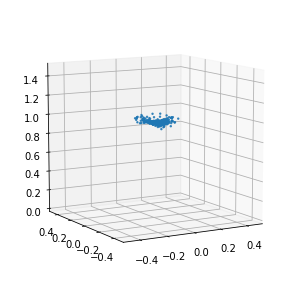

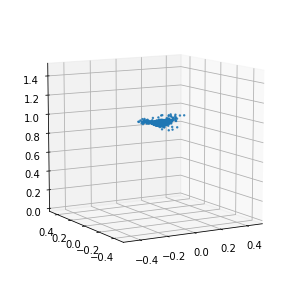

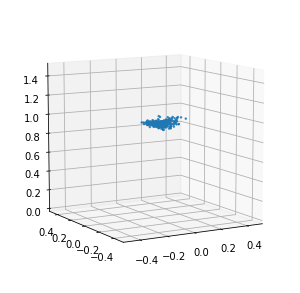

3901 (-0.03712219297885895, 0.36218884587287903)
3902 (-0.03382796049118042, 0.2865005433559418)
3903 (-0.016535885632038116, 0.18214507400989532)
3904 (-0.037779686599969865, 0.20128019154071808)
3905 (-0.031231353431940077, 0.24010032415390015)
3906 (-0.02029666304588318, 0.35250750184059143)
3907 (-0.019200335443019866, 0.2910454571247101)
3908 (-0.035815446823835376, 0.3353751301765442)
3909 (-0.025921815633773805, 0.2949426770210266)
3910 (-0.029464739561080932, 0.32759955525398254)
3911 (-0.02463490068912506, 0.25914108753204346)
3912 (-0.04204604476690292, 0.3275696039199829)
3913 (-0.02884058505296707, 0.3563575744628906)
3914 (-0.026436545699834824, 0.3006003499031067)
3915 (-0.02007894441485405, 0.2660459876060486)
3916 (-0.05392802506685257, 0.3305106461048126)
3917 (-0.012157389521598816, 0.28656670451164246)
3918 (-0.023782040178775787, 0.19530124962329865)
3919 (-0.039126695692539216, 0.19179929792881012)
3920 (-0.03756778836250305, 0.19105295836925507)
3921 (-0.058012725

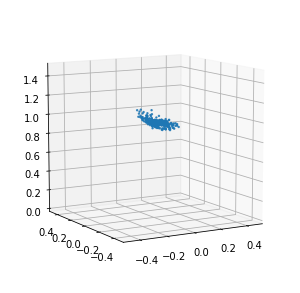

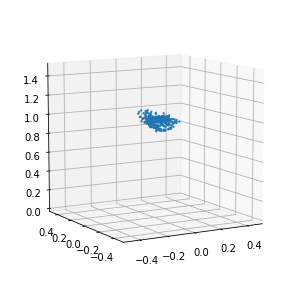

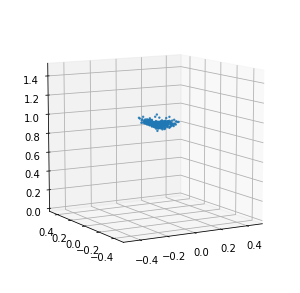

3951 (-0.01884365975856781, 0.3288775682449341)
3952 (-0.02930757626891136, 0.2670954763889313)
3953 (-0.04130590856075287, 0.2950214445590973)
3954 (-0.02568109631538391, 0.2620254158973694)
3955 (-0.028866928070783615, 0.2184588611125946)
3956 (-0.030041726678609847, 0.231944277882576)
3957 (-0.03516362830996513, 0.29354962706565857)
3958 (-0.02726125419139862, 0.25325751304626465)
3959 (-0.025246353447437288, 0.28712502121925354)
3960 (-0.020539476722478866, 0.2747536897659302)
3961 (-0.014061082154512405, 0.24512268602848053)
3962 (-0.04724525734782219, 0.3011183440685272)
3963 (-0.03700040653347969, 0.32925641536712646)
3964 (-0.031191062182188034, 0.3552757203578949)
3965 (-0.01983751431107521, 0.2853035628795624)
3966 (-0.039633005112409594, 0.3000718057155609)
3967 (-0.023774942755699156, 0.35411742329597473)
3968 (-0.014010801911354065, 0.3126986026763916)
3969 (-0.028422687947750092, 0.3390742540359497)
3970 (-0.042389798909425735, 0.3110484778881073)
3971 (-0.042954264581203

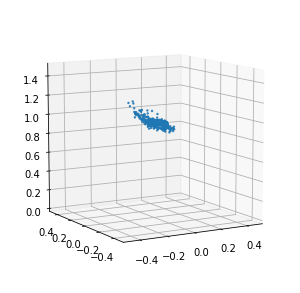

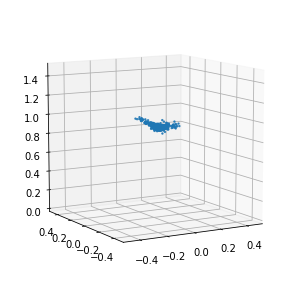

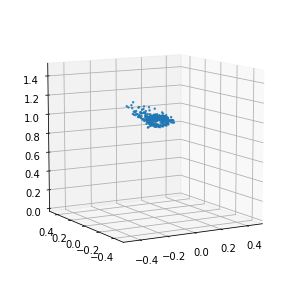

4001 (-0.041163145750761035, 0.40184006094932556)
4002 (-0.02528224214911461, 0.27539581060409546)
4003 (-0.032584623992443086, 0.2120235562324524)
4004 (-0.03506995514035225, 0.2997279465198517)
4005 (-0.03888414204120636, 0.33263108134269714)
4006 (-0.06337988525629043, 0.3777262568473816)
4007 (-0.03683675229549408, 0.28924819827079773)
4008 (-0.04797564744949341, 0.3002854287624359)
4009 (-0.03129747360944748, 0.2266923487186432)
4010 (-0.05778422951698303, 0.22598564624786377)
4011 (-0.04699709042906761, 0.26089808344841003)
4012 (-0.05178722813725471, 0.34913671016693115)
4013 (-0.030032441765069962, 0.20806482434272766)
4014 (-0.04534726217389107, 0.26387500762939453)
4015 (-0.04136510193347931, 0.2526519298553467)
4016 (-0.03638017252087593, 0.2855444848537445)
4017 (-0.02434810996055603, 0.2952708899974823)
4018 (-0.03915293365716934, 0.32848435640335083)
4019 (-0.016551414132118226, 0.24726681411266327)
4020 (-0.032979442924261096, 0.2767484188079834)
4021 (-0.025531489402055

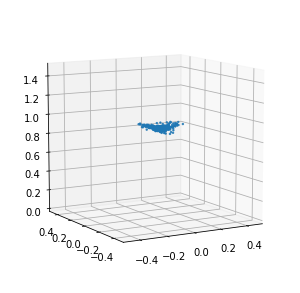

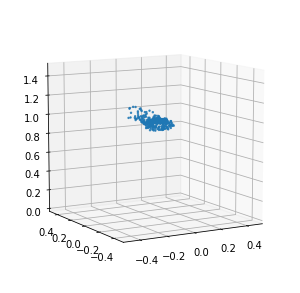

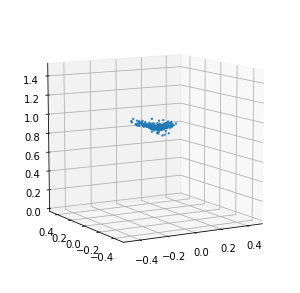

4051 (-0.04434643313288689, 0.2737292945384979)
4052 (-0.02547363266348839, 0.257877916097641)
4053 (-0.024542787671089174, 0.20242677628993988)
4054 (-0.03626528680324555, 0.23752163350582123)
4055 (-0.03342879489064217, 0.2405901402235031)
4056 (-0.026520504057407378, 0.2098977118730545)
4057 (-0.02875453233718872, 0.21444927155971527)
4058 (-0.031862997263669965, 0.22614505887031555)
4059 (-0.04200564548373222, 0.25175872445106506)
4060 (-0.03121938407421112, 0.30717918276786804)
4061 (-0.03789511620998383, 0.32197678089141846)
4062 (-0.04083503484725952, 0.26524338126182556)
4063 (-0.01762266382575035, 0.2826383709907532)
4064 (-0.029255276173353197, 0.32950469851493835)
4065 (-0.03286606371402741, 0.18466556072235107)
4066 (-0.03076022118330002, 0.13544976711273193)
4067 (-0.03635873273015022, 0.2266136109828949)
4068 (-0.03107811138033867, 0.28556397557258606)
4069 (-0.01420823484659195, 0.22917304933071136)
4070 (-0.062185736000537874, 0.3086748421192169)
4071 (-0.03297903463244

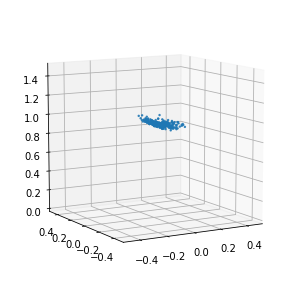

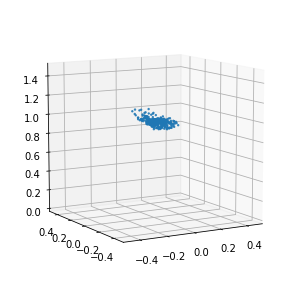

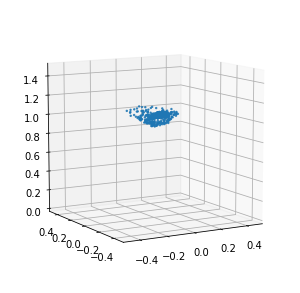

4101 (-0.029920271784067153, 0.29575207829475403)
4102 (-0.03172767758369446, 0.23080436885356903)
4103 (-0.02485998794436455, 0.24485424160957336)
4104 (-0.029746922105550765, 0.25548604130744934)
4105 (-0.018221890926361083, 0.28922152519226074)
4106 (-0.03659101501107216, 0.2298697680234909)
4107 (-0.03389467373490333, 0.24255576729774475)
4108 (-0.036878202855587, 0.18612168729305267)
4109 (-0.04628455936908722, 0.33127281069755554)
4110 (-0.031148684769868852, 0.2712501883506775)
4111 (-0.036251284182071686, 0.17931875586509705)
4112 (-0.049708998203277587, 0.19596520066261292)
4113 (-0.04966699331998825, 0.27441731095314026)
4114 (-0.032215990126132965, 0.2696497440338135)
4115 (-0.030591852217912673, 0.22952692210674286)
4116 (-0.038900145888328554, 0.2822096645832062)
4117 (-0.0391803927719593, 0.3312104344367981)
4118 (-0.032563789188861846, 0.2328246533870697)
4119 (-0.043154186010360716, 0.23626190423965454)
4120 (-0.0361261747777462, 0.19385437667369843)
4121 (-0.0389307893

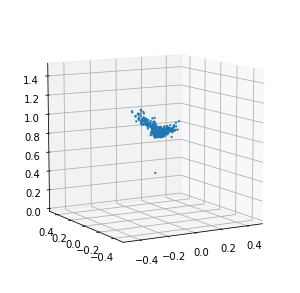

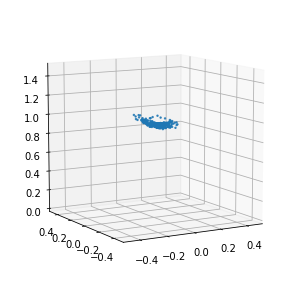

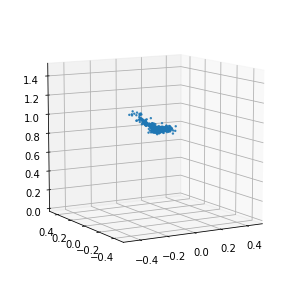

4151 (-0.03903699368238449, 0.22340059280395508)
4152 (-0.0350234143435955, 0.2242024540901184)
4153 (-0.05060381963849068, 0.27631857991218567)
4154 (-0.04530678391456604, 0.2192620038986206)
4155 (-0.04255511984229088, 0.15283754467964172)
4156 (-0.029996799677610396, 0.30979931354522705)
4157 (-0.037348420917987825, 0.33342650532722473)
4158 (-0.03494384065270424, 0.31000909209251404)
4159 (-0.04437345117330551, 0.2703665494918823)
4160 (-0.05179017335176468, 0.3610697090625763)
4161 (-0.04840442314743996, 0.30597740411758423)
4162 (-0.04615844190120697, 0.3641504943370819)
4163 (-0.04629845023155212, 0.27046331763267517)
4164 (-0.041802366822957994, 0.22475826740264893)
4165 (-0.03930247500538826, 0.27920764684677124)
4166 (-0.04436361640691757, 0.24977532029151917)
4167 (-0.03584104776382446, 0.287638783454895)
4168 (-0.03220157772302627, 0.3405528962612152)
4169 (-0.042223402112722394, 0.38598495721817017)
4170 (-0.03694279119372368, 0.3418896794319153)
4171 (-0.04084615036845207

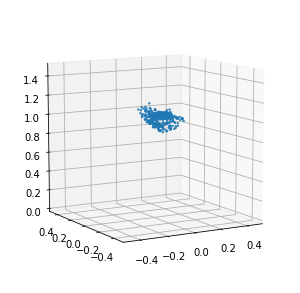

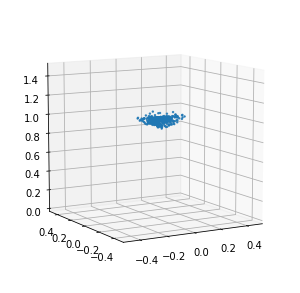

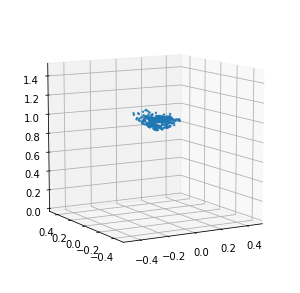

4201 (-0.0326730415225029, 0.31536543369293213)
4202 (-0.03118622228503227, 0.3016337454319)
4203 (-0.043537800759077074, 0.35051363706588745)
4204 (-0.04257935360074043, 0.3557603359222412)
4205 (-0.034124449640512464, 0.3831164538860321)
4206 (-0.03573896884918213, 0.35277122259140015)
4207 (-0.03149128630757332, 0.2628277838230133)
4208 (-0.058332082629203794, 0.2647979259490967)
4209 (-0.024273739755153657, 0.29911091923713684)
4210 (-0.032880426943302156, 0.31835660338401794)
4211 (-0.041072679311037065, 0.3088982105255127)
4212 (-0.047605162113904954, 0.39384138584136963)
4213 (-0.036482570320367814, 0.41814300417900085)
4214 (-0.03409500643610954, 0.3334499001502991)
4215 (-0.0452781617641449, 0.355276495218277)
4216 (-0.030830658972263336, 0.3162294626235962)
4217 (-0.04619504436850548, 0.2329593300819397)
4218 (-0.032112371921539304, 0.2525068521499634)
4219 (-0.042249154299497604, 0.27622660994529724)
4220 (-0.0500335119664669, 0.4025704860687256)
4221 (-0.04173802509903908, 

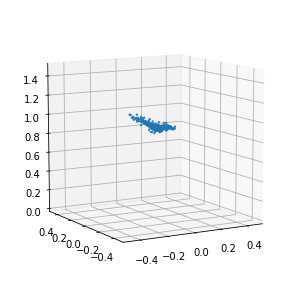

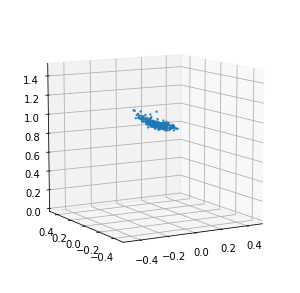

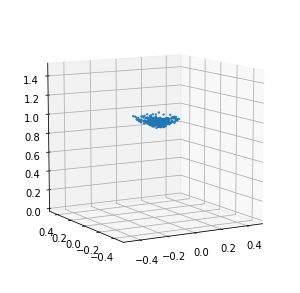

4251 (-0.04477242976427078, 0.2290346920490265)
4252 (-0.028147462010383605, 0.2685690224170685)
4253 (-0.04789532721042633, 0.3559620678424835)
4254 (-0.04186349585652351, 0.2949375808238983)
4255 (-0.03574129715561867, 0.2474803328514099)
4256 (-0.04168933480978012, 0.25477105379104614)
4257 (-0.05020813047885895, 0.34875497221946716)
4258 (-0.05366067662835121, 0.4103260040283203)
4259 (-0.02870934009552002, 0.22773924469947815)
4260 (-0.01582026109099388, 0.3694048225879669)
4261 (-0.02285558804869652, 0.16898766160011292)
4262 (-0.039083322137594224, 0.27311116456985474)
4263 (-0.04990644007921219, 0.2969876229763031)
4264 (-0.037466006726026534, 0.25917622447013855)
4265 (-0.04023730605840683, 0.2619636058807373)
4266 (-0.04217758849263191, 0.23348823189735413)
4267 (-0.04878982231020927, 0.3139854669570923)
4268 (-0.04259283617138863, 0.28509604930877686)
4269 (-0.047411874681711194, 0.31640368700027466)
4270 (-0.043564924597740175, 0.26603156328201294)
4271 (-0.0472299158573150

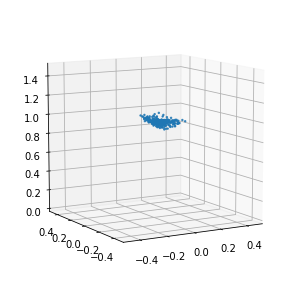

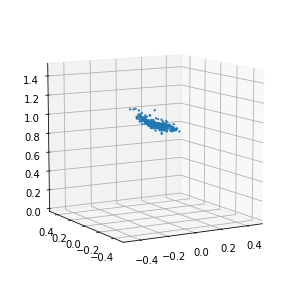

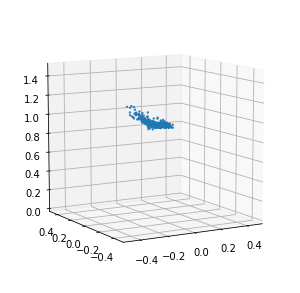

4301 (-0.032829596847295764, 0.2376861572265625)
4302 (-0.03707269951701164, 0.2518079876899719)
4303 (-0.032071316987276076, 0.23611602187156677)
4304 (-0.04374819695949554, 0.31907597184181213)
4305 (-0.04153747409582138, 0.24685309827327728)
4306 (-0.047937934100627896, 0.281950980424881)
4307 (-0.029650091379880904, 0.2676192820072174)
4308 (-0.03538438007235527, 0.24638855457305908)
4309 (-0.03452372625470161, 0.21113939583301544)
4310 (-0.037595277279615404, 0.2643939256668091)
4311 (-0.04356902614235878, 0.1764708310365677)
4312 (-0.03189144879579544, 0.139330193400383)
4313 (-0.03993031308054924, 0.23278415203094482)
4314 (-0.04322324767708778, 0.2595634162425995)
4315 (-0.03540146946907043, 0.27138692140579224)
4316 (-0.04345858320593834, 0.24096126854419708)
4317 (-0.051148999482393265, 0.25627949833869934)
4318 (-0.04470234736800194, 0.23673908412456512)
4319 (-0.049778377264738084, 0.2726311683654785)
4320 (-0.036923497915267944, 0.28852149844169617)
4321 (-0.03357036337256

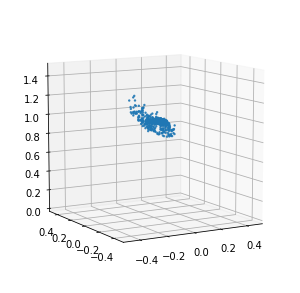

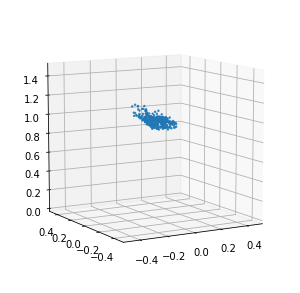

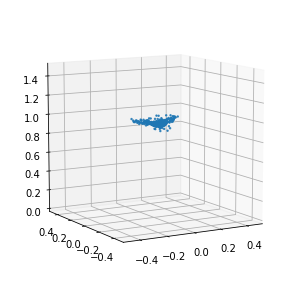

4351 (-0.04082850217819214, 0.31560057401657104)
4352 (-0.03095197081565857, 0.26996663212776184)
4353 (-0.061725690960884094, 0.3304826021194458)
4354 (-0.03379637748003006, 0.21958301961421967)
4355 (-0.04028421342372894, 0.2409394234418869)
4356 (-0.05328307524323463, 0.23896434903144836)
4357 (-0.040397456288337706, 0.24512863159179688)
4358 (-0.027142958343029024, 0.20555882155895233)
4359 (-0.04243892282247543, 0.3091452419757843)
4360 (-0.04770704507827759, 0.44981202483177185)
4361 (-0.028175031393766405, 0.33911705017089844)
4362 (-0.04157861396670341, 0.2789055109024048)
4363 (-0.04908121824264526, 0.3216574490070343)
4364 (-0.02436387613415718, 0.24338427186012268)
4365 (-0.03127135783433914, 0.2427215427160263)
4366 (-0.030759502947330476, 0.2690543830394745)
4367 (-0.04102800264954567, 0.28949829936027527)
4368 (-0.04073679000139237, 0.25103867053985596)
4369 (-0.03920203596353531, 0.2642025053501129)
4370 (-0.046948064118623734, 0.2914845943450928)
4371 (-0.03237787559628

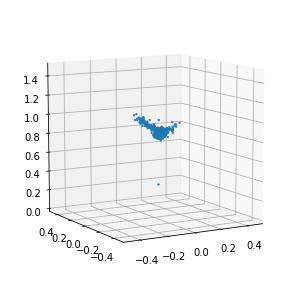

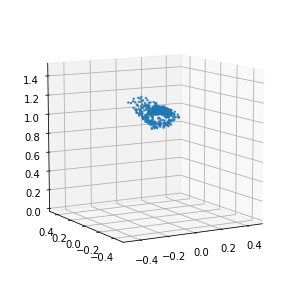

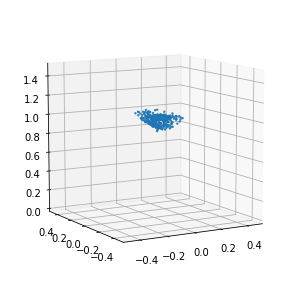

4401 (-0.03753982782363892, 0.2670736312866211)
4402 (-0.05545785129070282, 0.24214358627796173)
4403 (-0.05140909850597382, 0.21500982344150543)
4404 (-0.04019962623715401, 0.24739006161689758)
4405 (-0.04993904381990433, 0.3817731440067291)
4406 (-0.02793728858232498, 0.164638951420784)
4407 (-0.03187250345945358, 0.1252657175064087)
4408 (-0.04717458784580231, 0.1925995647907257)
4409 (-0.030964509397745133, 0.19084897637367249)
4410 (-0.035543131083250044, 0.23060192167758942)
4411 (-0.03688712120056152, 0.2627348303794861)
4412 (-0.04199774488806725, 0.22526048123836517)
4413 (-0.031080134212970734, 0.1905677765607834)
4414 (-0.03315400555729866, 0.1616164594888687)
4415 (-0.039222559332847594, 0.19142282009124756)
4416 (-0.04078296273946762, 0.1934097707271576)
4417 (-0.043444950878620145, 0.16797220706939697)
4418 (-0.04467747360467911, 0.1694348156452179)
4419 (-0.033218421041965485, 0.16598686575889587)
4420 (-0.0442795529961586, 0.11061511188745499)
4421 (-0.03858692944049835

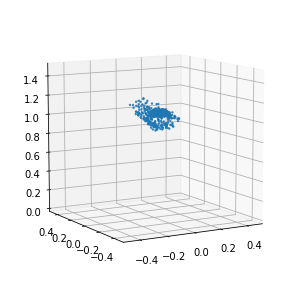

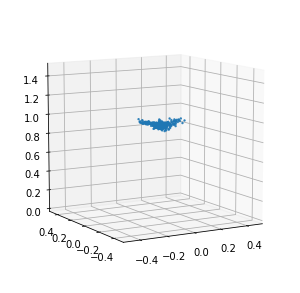

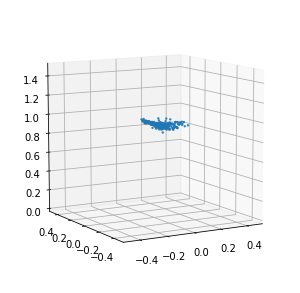

4451 (-0.05151735991239548, 0.27617347240448)
4452 (-0.042275813221931455, 0.2836478054523468)
4453 (-0.038226325809955594, 0.2716793119907379)
4454 (-0.041653835028409955, 0.35546547174453735)
4455 (-0.03778801411390305, 0.23558847606182098)
4456 (-0.04373533502221107, 0.2385701686143875)
4457 (-0.0389451414346695, 0.30835387110710144)
4458 (-0.03324235454201698, 0.24670687317848206)
4459 (-0.045217080414295195, 0.22697502374649048)
4460 (-0.044615019112825394, 0.1624361276626587)
4461 (-0.0389277346432209, 0.18681465089321136)
4462 (-0.05155622437596321, 0.1996372640132904)
4463 (-0.03450558558106422, 0.1694171130657196)
4464 (-0.050381676852703096, 0.23425444960594177)
4465 (-0.05048213675618172, 0.22654253244400024)
4466 (-0.03973972648382187, 0.138029083609581)
4467 (-0.03944640830159187, 0.20439459383487701)
4468 (-0.0453524574637413, 0.25143659114837646)
4469 (-0.0544706217944622, 0.3068296015262604)
4470 (-0.038675247132778166, 0.17288237810134888)
4471 (-0.053779997676610944, 

ResourceExhaustedError: ../data/OUT/raw_gan/raw_ear_gan_with_w_gan_loss/models.ckpt-4500.data-00000-of-00001.tempstate13378572008777328637; No space left on device
	 [[node raw_ear_gan_with_w_gan_loss_1/save/SaveV2 (defined at /home/dmri/github/latent_3d_points/src/w_gan_gp.py:68)  = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_raw_ear_gan_with_w_gan_loss_1/save/Const_0_0, raw_ear_gan_with_w_gan_loss_1/save/SaveV2/tensor_names, raw_ear_gan_with_w_gan_loss_1/save/SaveV2/shape_and_slices, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/_49, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/_51, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/_53, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/_55, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/_57, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/_59, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/_61, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/_63, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/_65, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/_67, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/_69, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/_71, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/_73, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/_75, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/_77, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/_79, raw_ear_gan_with_w_gan_loss/epoch, raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/_81, raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/_83, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/_85, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/_87, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/_89, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/_91, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/_93, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/_95, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/_97, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/_99, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/Adam/_101, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/Adam_1/_103, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/Adam/_105, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/Adam_1/_107, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/Adam/_109, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/Adam_1/_111, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/Adam/_113, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/Adam_1/_115, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/Adam/_117, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/Adam_1/_119, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/Adam/_121, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/Adam_1/_123, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/Adam/_125, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/Adam_1/_127, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/Adam/_129, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/Adam_1/_131, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/Adam/_133, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/Adam_1/_135, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/Adam/_137, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/Adam_1/_139, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/Adam/_141, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/Adam_1/_143, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/Adam/_145, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/Adam_1/_147, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/Adam/_149, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/Adam_1/_151, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/Adam/_153, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/Adam_1/_155, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/Adam/_157, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/Adam_1/_159, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/Adam/_161, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/Adam_1/_163, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/Adam/_165, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/Adam_1/_167, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/Adam/_169, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/Adam_1/_171, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/Adam/_173, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/Adam_1/_175, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/Adam/_177, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/Adam_1/_179, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/Adam/_181, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/Adam_1/_183, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/Adam/_185, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/Adam_1/_187, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/Adam/_189, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/Adam_1/_191, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/Adam/_193, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/Adam_1/_195, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/Adam/_197, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/Adam_1/_199, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/Adam/_201, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/Adam_1/_203, raw_ear_gan_with_w_gan_loss_1/beta1_power/_205, raw_ear_gan_with_w_gan_loss_1/beta1_power_1/_207, raw_ear_gan_with_w_gan_loss_1/beta2_power/_209, raw_ear_gan_with_w_gan_loss_1/beta2_power_1/_211)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'raw_ear_gan_with_w_gan_loss_1/save/SaveV2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dmri/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/gen.py", line 1152, in inner
    self.run()
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/dmri/.local/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dmri/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dmri/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dmri/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dmri/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-39ce743f653c>", line 8, in <module>
    disc_kwargs=disc_kwargs, beta=beta)
  File "/home/dmri/github/latent_3d_points/src/w_gan_gp.py", line 68, in __init__
    self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=None)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 792, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 284, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 202, in save_op
    tensors)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1690, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/dmri/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): ../data/OUT/raw_gan/raw_ear_gan_with_w_gan_loss/models.ckpt-4500.data-00000-of-00001.tempstate13378572008777328637; No space left on device
	 [[node raw_ear_gan_with_w_gan_loss_1/save/SaveV2 (defined at /home/dmri/github/latent_3d_points/src/w_gan_gp.py:68)  = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_raw_ear_gan_with_w_gan_loss_1/save/Const_0_0, raw_ear_gan_with_w_gan_loss_1/save/SaveV2/tensor_names, raw_ear_gan_with_w_gan_loss_1/save/SaveV2/shape_and_slices, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/_49, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/_51, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/_53, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/_55, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/_57, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/_59, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/_61, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/_63, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/_65, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/_67, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/_69, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/_71, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/_73, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/_75, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/_77, raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/_79, raw_ear_gan_with_w_gan_loss/epoch, raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/_81, raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/_83, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/_85, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/_87, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/_89, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/_91, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/_93, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/_95, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/_97, raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/_99, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/Adam/_101, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/W/Adam_1/_103, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/Adam/_105, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_0/b/Adam_1/_107, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/Adam/_109, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/W/Adam_1/_111, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/Adam/_113, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_1/b/Adam_1/_115, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/Adam/_117, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/W/Adam_1/_119, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/Adam/_121, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/decoding_logits/decoder_fc_2/b/Adam_1/_123, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/Adam/_125, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/W/Adam_1/_127, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/Adam/_129, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_0/b/Adam_1/_131, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/Adam/_133, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/W/Adam_1/_135, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/Adam/_137, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_1/b/Adam_1/_139, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/Adam/_141, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/W/Adam_1/_143, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/Adam/_145, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_2/b/Adam_1/_147, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/Adam/_149, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/W/Adam_1/_151, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/Adam/_153, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_3/b/Adam_1/_155, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/Adam/_157, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/W/Adam_1/_159, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/Adam/_161, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/discriminator/raw_ear_gan_with_w_gan_loss/discriminator/encoder_conv_layer_4/b/Adam_1/_163, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/Adam/_165, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/W/Adam_1/_167, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/Adam/_169, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/FullyConnected/b/Adam_1/_171, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/Adam/_173, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/W/Adam_1/_175, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/Adam/_177, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_0/b/Adam_1/_179, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/Adam/_181, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/W/Adam_1/_183, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/Adam/_185, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_1/b/Adam_1/_187, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/Adam/_189, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/W/Adam_1/_191, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/Adam/_193, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_2/b/Adam_1/_195, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/Adam/_197, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/W/Adam_1/_199, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/Adam/_201, raw_ear_gan_with_w_gan_loss/raw_ear_gan_with_w_gan_loss/generator/decoder_fc_3/b/Adam_1/_203, raw_ear_gan_with_w_gan_loss_1/beta1_power/_205, raw_ear_gan_with_w_gan_loss_1/beta1_power_1/_207, raw_ear_gan_with_w_gan_loss_1/beta2_power/_209, raw_ear_gan_with_w_gan_loss_1/beta2_power_1/_211)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [8]:
# Train the GAN.
for _ in range(n_epochs):
    loss, duration = gan._single_epoch_train(all_pc_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
    print(epoch, loss)

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_data = gan.generate(n_syn_samples, noise_params)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (synthetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('GAN training. (%s)' %(class_name))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')